In [6]:
!pip install lightgbm

In [8]:
!pip install bayesian-optimization

  Stored in directory: C:\Users\Asmita\AppData\Local\pip\Cache\wheels\5a\56\ae\e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


<h2> Importing Models </h2>

In [9]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import datetime
import tables
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, log_loss
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import make_scorer
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

<h2> Helper Function </h2>

In [378]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Load data into pandas and save memory with this function.

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<h2> Reading data </h2>

In [379]:
'''
    Reference: https://www.kaggle.com/brendanhasz/elo-data-cleaning-and-eda
'''
dtypes1 = {
  'card_id':            'str',     
  'target':             'float32', 
  'first_active_month': 'str',    
  'feature_1':          'uint8',   
  'feature_2':          'uint8',   
  'feature_3':          'uint8',   
}

dtypes2 = {
  'card_id':            'str',    
  'first_active_month': 'str',     
  'feature_1':          'uint8',   
  'feature_2':          'uint8',   
  'feature_3':          'uint8',   
}

dtypes3 = {
    'authorized_flag':      'str',    
    'card_id':              'str',     
    'city_id':              'int16',   
    'category_1':           'str',     
    'installments':         'int8',    
    'category_3':           'str',    
    'merchant_category_id': 'int16',   
    'merchant_id':          'str',     
    'month_lag':            'int8',    
    'purchase_amount':      'float32', 
    'purchase_date':        'str',     
    'category_2':           'float32', 
    'state_id':             'int8',    
    'subsector_id':         'int8'     
}

dtypes4 = {
  'merchant_id':                 'str',     
  'merchant_group_id':           'uint32',  
  'numerical_1':                 'float32', 
  'numerical_2':                 'float32', 
  'most_recent_sales_range':     'str',     
  'most_recent_purchases_range': 'str',     
  'avg_sales_lag3':              'float32',
  'avg_purchases_lag3':          'float32', 
  'active_months_lag3':          'uint8',   
  'avg_sales_lag6':              'float32', 
  'avg_purchases_lag6':          'float32', 
  'active_months_lag6':          'uint8',   
  'avg_sales_lag12':             'float32',
  'avg_purchases_lag12':         'float32',
  'active_months_lag12':         'uint8',  
  'category_4':                  'str',     
}

In [4]:
%%time
#Reading datasets

train = reduce_mem_usage(pd.read_csv("train.csv", parse_dates=["first_active_month"], usecols=dtypes1.keys(), dtype=dtypes1))

test = reduce_mem_usage(pd.read_csv("test.csv", parse_dates=["first_active_month"], usecols=dtypes2.keys(), dtype=dtypes2))

hist_tran = reduce_mem_usage(pd.read_csv("historical_transactions.csv", parse_dates=["purchase_date"], usecols=dtypes3.keys(), dtype=dtypes3))

new_merch_tran = reduce_mem_usage(pd.read_csv("new_merchant_transactions.csv", parse_dates=["purchase_date"], usecols=dtypes3.keys(), dtype=dtypes3))

merch = reduce_mem_usage(pd.read_csv("merchants.csv", usecols=dtypes4.keys(), dtype=dtypes4))

Mem. usage decreased to  4.04 Mb (8.7% reduction)
Mem. usage decreased to  2.24 Mb (0.0% reduction)
Mem. usage decreased to 1721.35 Mb (3.1% reduction)
Mem. usage decreased to 112.33 Mb (6.2% reduction)
Mem. usage decreased to 25.22 Mb (-11.3% reduction)
CPU times: user 51.7 s, sys: 4.73 s, total: 56.5 s
Wall time: 57.9 s


In [11]:
train.shape

(201917, 6)

In [12]:
test.shape

(123623, 5)

In [80]:
hist_tran.shape

(29112361, 14)

In [14]:
new_merch_tran.shape

(1963031, 14)

In [15]:
merch.shape

(334696, 16)

In [193]:
import gc
del train, test
gc.collect()

21

<h2> Handling missing values </h2>

In [5]:
%%time
train_lst = train.columns[train.isnull().any()].tolist()
print("All the columns in train data that have null values are", train_lst)

test_lst = test.columns[test.isnull().any()].tolist()
print("All the columns in test data that have null values are", test_lst)

hist_lst = hist_tran.columns[hist_tran.isnull().any()].tolist()
print("All the columns in historical transactions data that have null values are", hist_lst)

new_merch_lst = new_merch_tran.columns[new_merch_tran.isnull().any()].tolist()
print("All the columns in new merchant transactions data that have null values are", new_merch_lst)

merch_lst = merch.columns[merch.isnull().any()].tolist()
print("All the columns in merchants data that have null values are", merch_lst)

All the columns in train data that have null values are []
All the columns in test data that have null values are ['first_active_month']
All the columns in historical transactions data that have null values are ['category_3', 'merchant_id', 'category_2']
All the columns in new merchant transactions data that have null values are ['category_3', 'merchant_id', 'category_2']
All the columns in merchants data that have null values are ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']
CPU times: user 6.31 s, sys: 17.6 ms, total: 6.32 s
Wall time: 6.3 s


As we want to retain the number of rows in test data I will fill null value present in test set with zero (0) value. As we will be performing featurization it will still be correct.

In [6]:
print(test.isnull().sum().sum())
test['first_active_month'] = test['first_active_month'].fillna(method='bfill')
print(test.isnull().sum().sum())

1
0


In [7]:
%%time
print("Percent of missing values in historical transactions")
p = np.round(hist_tran.category_3.isnull().sum()/hist_tran.shape[0],2)
print("Category_3 has {0}% of missing values".format(p*100))
print()

p = np.round(hist_tran.category_2.isnull().sum()/hist_tran.shape[0],2)
print("Category_2 has {0}% of missing values".format(p*100))
print()

p = np.round(hist_tran.merchant_id.isnull().sum()/hist_tran.shape[0],2)
print("merchant_id has {0}% of missing values".format(p*100))

print("="*100)
print("Percent of missing values in new merchant transactions")
p = np.round(new_merch_tran.category_3.isnull().sum()/new_merch_tran.shape[0],2)
print("Category_3 has {0}% of missing values".format(p*100))
print()

p = np.round(new_merch_tran.category_2.isnull().sum()/new_merch_tran.shape[0],2)
print("Category_2 has {0}% of missing values".format(p*100))
print()

p = np.round(new_merch_tran.merchant_id.isnull().sum()/new_merch_tran.shape[0],2)
print("merchant_id has {0}% of missing values".format(p*100))
print()

print("="*100)
print("Percent of missing values in merchants data")
p = np.round(merch.avg_sales_lag3.isnull().sum()/merch.shape[0],2)
print("avg_sales_lag3 has {0}% of missing values".format(p*100))
print()

p = np.round(merch.avg_sales_lag6.isnull().sum()/merch.shape[0],2)
print("avg_sales_lag6 has {0}% of missing values".format(p*100))
print()

p = np.round(merch.avg_sales_lag12.isnull().sum()/merch.shape[0],2)
print("avg_sales_lag12 has {0}% of missing values".format(p*100))
print()

Percent of missing values in historical transactions
Category_3 has 1.0% of missing values

Category_2 has 9.0% of missing values

merchant_id has 0.0% of missing values
Percent of missing values in new merchant transactions
Category_3 has 3.0% of missing values

Category_2 has 6.0% of missing values

merchant_id has 1.0% of missing values

Percent of missing values in merchants data
avg_sales_lag3 has 0.0% of missing values

avg_sales_lag6 has 0.0% of missing values

avg_sales_lag12 has 0.0% of missing values

CPU times: user 2.66 s, sys: 4.35 ms, total: 2.67 s
Wall time: 2.65 s


In [8]:
for i in hist_lst:
    print(i, "is", hist_tran[i].dtype ,'data type')

category_3 is object data type
merchant_id is object data type
category_2 is float16 data type


In [9]:
for i in merch_lst:
    print(i, "is", merch[i].dtype ,'data type')

avg_sales_lag3 is float32 data type
avg_sales_lag6 is float32 data type
avg_sales_lag12 is float32 data type


In [7]:
def missing_value(df, lst):
    '''
        This function is to fill up the missing values in dataframe
        df - dataframe having missing values
        lst - names of features which has NaN values
        
    '''
    for col in lst:
        if df[col].dtype == 'object':
            null_lst = df[df[col].isnull()].index.tolist()
            df.loc[null_lst, col] = df[col].mode()[0]
        else:
            null_lst = df[df[col].isnull()].index.tolist()
            df.loc[null_lst, col] = df[col].median() #because mean value gives nan value
    print("Successfully done!!!!")
    return df

In [8]:
print("Handing missing values in historical transactions data")
hist_tran = missing_value(hist_tran, hist_lst)
print("="*100)

print("Handing missing values in new merchants transactions data")
new_merch_tran = missing_value(new_merch_tran, new_merch_lst)
print("="*100)

print("Handing missing values in merchants transactions data")
merch = missing_value(merch, merch_lst)
print("="*100)

Handing missing values in historical transactions data
Successfully done!!!!
Handing missing values in new merchants transactions data
Successfully done!!!!
Handing missing values in merchants transactions data
Successfully done!!!!


<h2> Saving test data card ids for later use </h2>

In [9]:
train_ids = train.card_id
test_ids = test.card_id

In [37]:
train_ids.to_csv("train_ids.csv")
test_ids.to_csv("test_ids.csv")

In [201]:
test_ids.shape

(123623,)

<h2> Data Preprocessing </h2>

In [10]:
def preprocess_card_id(df):
    ''' 
        This function is used to convert string format card ids to numeric form of card ids. 
        This is to reduce the size of memory allocation by string (37+n bits per character) to int(4 bits per digit)
        df - dataframe having card_id
    '''
    df['card_id'] = df['card_id'].map(lambda x: x.lstrip('C_ID_'))
    df['card_id'] = df['card_id'].apply(lambda row: int(str(row), 16))
    return df

In [11]:
def preprocess_merch_id(df):
    ''' 
        This function is used to convert string format card ids to numeric form of merchant ids. 
        This is to reduce the size of memory allocation by string (37+n bits per character) to int(4 bits per digit)
        df - dataframe having merchant_id
    '''
    df['merchant_id'] = df['merchant_id'].apply(lambda x: x.lstrip('M_ID_'))
    df['merchant_id'] = df['merchant_id'].apply(lambda row: int(str(row), 16))
    return df

In [12]:
def preprocess_categorical(df):
    '''
        This function is used to perform label encoding of the categorical features in data.
        df - dataframe
    '''
    cat_features=[col for col in df.columns if df[col].dtype=='object']
    lenc = LabelEncoder()
    for i in cat_features:
        df[i] = lenc.fit_transform(df[i])
    return df

In [13]:
def preprocessing(train, test, hist_tran, new_merch_tran, merch):
    '''
        This function gives call to all the sub tasks needed to perfrom 
        (whose functions have been defined above) the preprocessing of data to make it model-ready.
        train - train df
        test - test df
        hist_tran - historical transaction file
        new_merch_tran - new merchant transaction file
        merch - merchant transaction file
    '''
    print("Preprocessing train set")
    train = preprocess_card_id(train)
    print()
    
    print("Preprocessing test set")
    test = preprocess_card_id(test)
    print()
    
    print("Preprocess historical transactions")
    hist_tran = preprocess_card_id(hist_tran)
    hist_tran = preprocess_merch_id(hist_tran)
    hist_tran = preprocess_categorical(hist_tran)
    print()
    
    print("Preprocess new merchants transactions")
    new_merch_tran = preprocess_card_id(new_merch_tran)
    new_merch_tran = preprocess_merch_id(new_merch_tran)
    new_merch_tran = preprocess_categorical(new_merch_tran)
    print()
    
    print("Preprocess merchants data")
    merch = preprocess_merch_id(merch)
    merch = preprocess_categorical(merch)
    print()
    
    print("PREPROCESSING DONE!!!")

In [14]:
%%time
preprocessing(train, test, hist_tran, new_merch_tran, merch)

Preprocessing train set

Preprocessing test set

Preprocess historical transactions

Preprocess new merchants transactions

Preprocess merchants data

PREPROCESSING DONE!!!
CPU times: user 1min 14s, sys: 4.25 s, total: 1min 18s
Wall time: 1min 18s


<h2> Feature Engineering </h2>

We will be creating new features per csv file. I intend to create four types of features. 
1. Date Based Features
2. RFM Features
3. Aggregated features
4. Successive Aggregates

<h2> Train and Test data sets </h2>
Here we create date based and aggregate features

In [15]:
'''
     Reference for some of the features - https://github.com/Rjt5412/Elo-Merchant-Category-Recommendation/blob/main/Feature%20Engineering/More_Feature_Engineering(Second_Iteration).ipynb
'''
#Date Based features
def train_n_test_features(data):
    '''
         This function is used to create date-based features (month, year, week of year, day of week etc)
         data - train, test file passed here
    '''
    data['first_active_month_month'] = data['first_active_month'].dt.month
    data['first_active_month_year'] = data['first_active_month'].dt.year
    data['first_active_month_weekofyear'] = data['first_active_month'].dt.weekofyear
    data['first_active_month_dayofweek'] = data['first_active_month'].dt.dayofweek
    data['first_active_month_weekend'] = (data.first_active_month.dt.weekday >=5).astype(int)
    data['first_active_month_hour'] = data['first_active_month'].dt.hour
    data['first_active_month_quarter'] = data['first_active_month'].dt.quarter  
    data['first_active_diff_from_today'] = (datetime.datetime.today() - data['first_active_month']).dt.days  
    data['first_active_month'] = (12*(data['first_active_month'].dt.year-2011) + 
                               data['first_active_month'].dt.month).astype('float32')
    
    
    #Products
    data['category_time_feature1'] = data['first_active_diff_from_today'] * data['feature_1'] 
    data['category_time_feature2'] = data['first_active_diff_from_today'] * data['feature_2'] 
    data['category_time_feature3'] = data['first_active_diff_from_today'] * data['feature_3'] 

    #Ratios
    data['category_time_ratio1'] = data['feature_1'] / data['first_active_diff_from_today'] 
    data['category_time_ratio2'] = data['feature_2'] / data['first_active_diff_from_today'] 
    data['category_time_ratio3'] = data['feature_3'] / data['first_active_diff_from_today'] 
    
    feature_cols = ['feature_1', 'feature_2', 'feature_3']  
    for f in feature_cols:
        data[ f + '_days'] = data['first_active_diff_from_today'] * data[f] 
        data[ f + '_days_ratio'] = data[f] / data['first_active_diff_from_today'] 
        
    
    return data

In [16]:
#Aggregated featues
agg1 = {
         'first_active_month_weekofyear' : ['nunique', 'mean', 'min', 'max'],
         'first_active_month_dayofweek' : ['nunique', 'mean', 'min', 'max'],
         'first_active_month_weekend' : ['nunique', 'mean', 'min', 'max'],
         'first_active_month_hour' : ['nunique', 'mean', 'min', 'max'],     
        }

def aggregated_train_test(df):
    '''
         This function is used to create aggregated features (sum, min, max, mean) grouped by on card_id feature.
         df - dataframe
    '''
    df_new = df.groupby(['card_id']).agg(agg1)
    
    temp_array = df_new.columns.values
    df_new.columns = ['_'.join(col).strip() for col in temp_array]
    df_new.reset_index(inplace=True)
    
    df = df.drop(['first_active_month_weekofyear', 'first_active_month_dayofweek', 'first_active_month_weekend', 'first_active_month_hour'], axis = 1)
    df = pd.merge_asof(df.sort_values('card_id'), df_new, on='card_id')
    return df

<h3> 1. Train data </h3>

In [17]:
%%time
train = train_n_test_features(train)

CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 268 ms


In [18]:
train.shape

(201917, 26)

In [19]:
%%time
train = aggregated_train_test(train)
train.shape

CPU times: user 454 ms, sys: 118 µs, total: 454 ms
Wall time: 461 ms


(201917, 38)

<h3>2. Test data</h3>

In [20]:
%%time
test = train_n_test_features(test)
test.shape

CPU times: user 168 ms, sys: 1e+03 ns, total: 168 ms
Wall time: 168 ms


(123623, 25)

In [21]:
%%time
test = aggregated_train_test(test)
test.shape

CPU times: user 255 ms, sys: 3.61 ms, total: 258 ms
Wall time: 257 ms


(123623, 37)

In [22]:
test.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'first_active_month_month', 'first_active_month_year',
       'first_active_month_quarter', 'first_active_diff_from_today',
       'category_time_feature1', 'category_time_feature2',
       'category_time_feature3', 'category_time_ratio1',
       'category_time_ratio2', 'category_time_ratio3', 'feature_1_days',
       'feature_1_days_ratio', 'feature_2_days', 'feature_2_days_ratio',
       'feature_3_days', 'feature_3_days_ratio',
       'first_active_month_weekofyear_nunique',
       'first_active_month_weekofyear_mean',
       'first_active_month_weekofyear_min',
       'first_active_month_weekofyear_max',
       'first_active_month_dayofweek_nunique',
       'first_active_month_dayofweek_mean', 'first_active_month_dayofweek_min',
       'first_active_month_dayofweek_max',
       'first_active_month_weekend_nunique', 'first_active_month_weekend_mean',
       'first_active_month_weekend_min', 'first_

<h2> Transactional data </h2>
Here we create all four types of features mentioned above

In [22]:
def transactional_features(data, name):
    '''
         This function is used to create date-based features (month, year, week of year, day of week etc)
         data - transactional (historical, new merchant) file passed here
         name - name of the dataframe - historical/new merchants
    '''
    data[name + '_' + 'purchase_month'] = data['purchase_date'].dt.month
    data[name  + '_' + 'purchase_year'] = data['purchase_date'].dt.year
    data['purchase_weekofyear'] = data['purchase_date'].dt.weekofyear
    data['purchase_dayofweek'] = data['purchase_date'].dt.dayofweek
    data['purchase_weekend'] = (data.purchase_date.dt.weekday >=5).astype(int)
    data['purchase_hour'] = data['purchase_date'].dt.hour
    data[name  + '_' + 'month_diff'] = ((datetime.datetime.today() - data['purchase_date']).dt.days)//30
    data[name  + '_' + 'month_diff'] += data['month_lag']
    
    reference_date = np.datetime64('2018-02-01')
    one_hr = np.timedelta64(1, 'h')

    tranPurchaseDate = data['purchase_date']
    data[name  + '_' +'purchase_time'] = ((tranPurchaseDate - reference_date) / one_hr).astype('float32')
    return data

In [23]:
'''
    Reference : https://www.kaggle.com/brendanhasz/elo-feature-engineering-and-feature-selection
'''
#Aggregated featues

def period(series):
    """Period of a series (max-min)"""
    return series.max() - series.min()

def mode(series):
    """Most common element in a series"""
    tmode = series.mode()
    if len(tmode) == 0:
        return np.nan
    else:
        return tmode[0]

agg2 = {
         'authorized_flag': ['sum', 'mean', 'min', 'max', mode, 'median', 'nunique'],
         
         'category_1': ['sum', 'mean', 'nunique'],

        'category_2_1.0': ['sum', 'mean', 'nunique'],
        'category_2_2.0': ['sum', 'mean', 'nunique'],
        'category_2_3.0': ['sum', 'mean', 'nunique'],
        'category_2_4.0': ['sum', 'mean', 'nunique'],
        'category_2_5.0': ['sum', 'mean', 'nunique'],

        'category_3_0': ['sum', 'mean', 'nunique'],
        'category_3_1': ['sum', 'mean', 'nunique'],
        'category_3_2': ['sum', 'mean', 'nunique'],
    
        'state_id': [ mode, 'nunique'],
        'city_id': [ mode, 'nunique'],
    
        'installments': ['sum', 'mean', 'max', 'min', mode,  period, 'median'],
    
        'merchant_id': [ mode, 'nunique'],
        'merchant_category_id': [ 'nunique'],
        'subsector_id': [ mode, 'nunique'],

        'month_lag': ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'purchase_amount' : ['sum', 'mean', 'max', 'min', mode, period, 'median'] , 
    
        'purchase_weekofyear': ['nunique', 'mean', 'min', 'max'],
        'purchase_dayofweek': ['nunique', 'mean', 'min', 'max'],
        'purchase_hour': ['nunique', 'mean', 'min', 'max'],
        'purchase_weekend' : ['nunique', 'mean', 'min', 'max'],
    
        #merchants features
        'category_4': ['sum', 'mean', 'nunique'],

        'merchant_group_id': [ 'nunique'],

        'numerical_1' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'numerical_2' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],

        'most_recent_sales_range' :  [ mode, 'mean'],
        'most_recent_purchases_range' : [ mode, 'mean'],

        'avg_sales_lag3' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'avg_purchases_lag3' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'active_months_lag3' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],

        'avg_sales_lag6' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'avg_purchases_lag6' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'active_months_lag6' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],

        'avg_sales_lag12' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'avg_purchases_lag12' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        'active_months_lag12' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
     }

agg3 = {
         'authorized_flag': ['sum', 'mean', 'min', 'max', mode, 'median', 'nunique'],
         
         'category_1': ['sum', 'mean', 'nunique'],

         'category_2_1.0': ['sum', 'mean', 'nunique'],
         'category_2_2.0': ['sum', 'mean', 'nunique'],
         'category_2_3.0': ['sum', 'mean', 'nunique'],
         'category_2_4.0': ['sum', 'mean', 'nunique'],
         'category_2_5.0': ['sum', 'mean', 'nunique'],

         'category_3_0': ['sum', 'mean', 'nunique'],
         'category_3_1': ['sum', 'mean', 'nunique'],
         'category_3_2': ['sum', 'mean', 'nunique'],
    
         'state_id': [ mode, 'nunique'],
         'city_id': [ mode, 'nunique'],
    
         'installments': ['sum', 'mean', 'max', 'min', mode,  period, 'median'],
    
         'merchant_id': [ mode, 'nunique'],
         'merchant_category_id': [ 'nunique'],
         'subsector_id': [ mode, 'nunique'],

         'month_lag': ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'purchase_amount' : ['sum', 'mean', 'max', 'min', mode, period, 'median'] , 
    
         'purchase_weekofyear': ['nunique', 'mean', 'min', 'max'],
         'purchase_dayofweek': ['nunique', 'mean', 'min', 'max'],
         'purchase_hour': ['nunique', 'mean', 'min', 'max'],
         'purchase_weekend' : ['nunique', 'mean', 'min', 'max'],
    
         #merchants features
         'category_4': ['sum', 'mean', 'nunique'],
    
         'merchant_group_id': [ 'nunique'],

         'numerical_1' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'numerical_2' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],

         'most_recent_sales_range' :  [ mode, 'mean'],
         'most_recent_purchases_range' : [ mode, 'mean'],

         'avg_sales_lag3' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'avg_purchases_lag3' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'active_months_lag3' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],

         'avg_sales_lag6' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'avg_purchases_lag6' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'active_months_lag6' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],

         'avg_sales_lag12' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'avg_purchases_lag12' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
         'active_months_lag12' : ['sum', 'mean', 'max', 'min', mode, period, 'median'],
        }



In [24]:
#Aggregated Features
def aggregated_transactional2(df, name):
    '''
        This function is used to create aggregated features (sum, min, max, mean) grouped by on card_id feature.
        df - dataframe
        name - name of file - historical/new merchant
    '''
    df_new = df.groupby(['card_id']).agg(agg2)
    
    temp_array = df_new.columns.values
    df_new.columns = [name + '_' + '_'.join(col).strip() for col in temp_array]
    df_new.reset_index(inplace=True)
    
    df = df.drop(['authorized_flag', 'category_1', 'category_2_1.0', 'category_2_2.0',
                  'category_2_3.0', 'category_2_4.0', 'category_2_5.0', 'category_3_0',
                  'category_3_1', 'category_3_2', 'state_id', 'city_id', 'installments', 
                  'merchant_id', 'merchant_category_id', 'subsector_id', 'month_lag', 
                  'purchase_amount', 'purchase_weekofyear', 
                  'purchase_dayofweek', 'purchase_hour',
                  'purchase_weekend', 'merchant_group_id', 'numerical_1', 'numerical_2',
                  'most_recent_sales_range', 'most_recent_purchases_range',
                  'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
                  'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
                  'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
                  'category_4'
                 ], axis = 1)
    df = pd.merge_asof(df.sort_values("card_id"), df_new, on='card_id')
    return df

def aggregated_transactional3(df, name):
    '''
         This function is used to create aggregated features (sum, min, max, mean) grouped by on card_id feature.
         df - dataframe
         name - name of file - historical/new merchant
    '''
    df_new = df.groupby(['card_id']).agg(agg3)
    #print(df_new.shape)
    
    temp_array = df_new.columns.values
    df_new.columns = [name + '_' + '_'.join(col).strip() for col in temp_array]
    df_new.reset_index(inplace=True)
    
    df = df.drop(['authorized_flag', 'category_1', 'category_2_1.0', 'category_2_2.0',
                  'category_2_3.0', 'category_2_4.0', 'category_2_5.0', 'category_3_0',
                  'category_3_1', 'category_3_2', 'state_id', 'city_id', 'installments', 
                  'merchant_id', 'merchant_category_id', 'subsector_id', 'month_lag', 
                  'purchase_amount', 'purchase_weekofyear', 
                  'purchase_dayofweek', 'purchase_hour',
                  'purchase_weekend', 'merchant_group_id', 'numerical_1', 'numerical_2',
                  'most_recent_sales_range', 'most_recent_purchases_range',
                  'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
                  'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
                  'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
                  'category_4'
                 ], axis = 1)
    df = pd.merge_asof(df.sort_values("card_id"), df_new, on='card_id')
    return df

In [25]:
merch.columns

Index(['merchant_id', 'merchant_group_id', 'numerical_1', 'numerical_2',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4'],
      dtype='object')

In [26]:
hist_tran.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [25]:
'''
     Reference : https://medium.com/capillary-data-science/rfm-analysis-an-effective-customer-segmentation-technique-using-python-58804480d232
                 https://medium.com/analytics-vidhya/customer-segmentation-with-rfm-analysis-kmeans-clustering-32c387d04dfe
'''

def distribution(df):
    '''
        Function to find optimal K value using sum of square errors
        df - data frame
    '''
    sum_sq_errors = {}
    for k in range(1, 20):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df)
        sum_sq_errors[k] = kmeans.inertia_
    
    # Plot SSE for each *k*
    plt.title('The Elbow Method')
    plt.xlabel('k'); 
    plt.ylabel('SSE')
    sns.pointplot(x=list(sum_sq_errors.keys()), y=list(sum_sq_errors.values()))
    plt.show()
    
def fitt(df,feature, k):
    '''
       Choose k=5 and fit data set to k-means model
       df - data frame
       feature - recency / frequency / monetary feature
       k - value of k
    ''' 
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df[[feature]])

    # Assign k-means labels to cluster labels
    cluster_labels = kmeans.labels_

    df[feature+'_cluster'] = cluster_labels
    return df

def cluster_order(cluster, feature, df, ascending):
    '''
          This function is used to sort and oreder the rfm features by its cluster to give us a new data frame
          cluster - recency / frequency / monetary cluster
          feature - recency or frequency or monetary cluster
          df - data frame
          ascending - sort in ascending order or not?
    '''
    new_cluster = 'new_' + cluster
    df_new = df.groupby(cluster)[feature].mean().reset_index()
    df_new = df_new.sort_values(by = feature, ascending = ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_fin = pd.merge(df, df_new[[cluster,'index']], on=cluster)
    df_fin = df_fin.drop([cluster],axis=1)
    df_fin = df_fin.rename(columns={"index":cluster})
    return df_fin


def rfm(df, name):
    '''
        This function creacted features RFM individually and returns the data frame.
        df - dataframe
        name - name of the file, historical or new merchants?
    '''
    max_date = df['purchase_date'].max() + np.timedelta64(1, 'D')
    df[name + '_' + 'recency'] = (max_date - df['purchase_date']).dt.days
    rec_df = df.groupby('card_id')[name + '_' + 'recency'].min()
    rec_df = rec_df.reset_index()
    distribution(rec_df)
    
    freq_df = df.groupby(['card_id']).agg({ 'purchase_date' : 'count'})
    freq_df = freq_df.reset_index()
    freq_df.columns = ['card_id',name + '_' + 'frequency']
    distribution(freq_df)
    
    monet_df = df.groupby(['card_id']).agg({ 'purchase_amount': 'sum'})
    monet_df = monet_df.reset_index()
    monet_df.columns = ['card_id', name + '_' + 'monetary']
    distribution(monet_df)
    
    return rec_df, freq_df, monet_df

In [26]:
def fit_cluster(rec_df, freq_df, monet_df, name):
    '''
         This function is used to give call to functions defined above. 
         It returns descending oredered feature cluster and feature data frame individually.
         rec_df - recency data frame
         freq_df - frequency data frame
         monet_df - moetary data frame
         name - name of the file - historical/new merchants
    '''
    rec_df = fitt(rec_df,name + '_' + 'recency', 5)
    rec_df = cluster_order(name + '_' + 'recency_cluster', name + '_' + 'recency',rec_df,False)
    
    freq_df = fitt(freq_df,name + '_' + 'frequency', 5)
    freq_df = cluster_order(name + '_' + 'frequency_cluster', name + '_' + 'frequency',freq_df,False)
    
    monet_df = fitt(monet_df,name + '_' + 'monetary', 5)
    monet_df = cluster_order(name + '_' + 'monetary_cluster', name + '_' + 'monetary',monet_df,False)
    
    return rec_df, freq_df, monet_df

In [27]:
def rfm_(rec_df, freq_df, monet_df, name):
    '''
         This function is used gives a final data frame, which consists of all three features (RFM) along with its cluster order. 
         Based on which a new feature is created, "Membership".
         rec_df - recency data frame
         freq_df - frequency data frame
         monet_df - moetary data frame
         name - name of the file - historical/new merchants
         
    '''
    
    rec_df, freq_df, monet_df = fit_cluster(rec_df, freq_df, monet_df, name = name)
    rfm = pd.merge(pd.merge(rec_df, freq_df, on='card_id', how = 'left'), monet_df, on='card_id', how = 'left')
    rfm.columns = ['card_id', name + '_' + 'recency', name + '_' + 'recency_cluster', name + '_' + 'frequency', name + '_' + 'frequency_cluster', name + '_' + 'monetary', name + '_' + 'monetary_cluster']
    
    rfm[name + '_' + 'RFMScore'] = rfm[name + '_' + 'recency_cluster'] + rfm[name + '_' + 'frequency_cluster'] + rfm[name + '_' + 'monetary_cluster']
    rfm[name + '_' + 'Membership'] = 'Platinum' #4
    rfm.loc[rfm[name + '_' + 'monetary_cluster'] < 4, name + '_' + 'Membership'] = 'Gold'   #3
    rfm.loc[rfm[name + '_' + 'monetary_cluster'] < 3, name + '_' + 'Membership'] = 'Silver' #1,2
    rfm.loc[rfm[name + '_' + 'monetary_cluster'] < 1, name + '_' + 'Membership'] = 'Bronze' #0
    
    return rfm

In [30]:
hist_tran.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [137]:
len(hist_tran.columns)

29

In [28]:
hist_tran = reduce_mem_usage(pd.merge(hist_tran, merch, on = 'merchant_id'))

Mem. usage decreased to 2877.00 Mb (29.8% reduction)


In [57]:
hist_tran.isnull().sum().sum()

0

In [29]:
%%time
hist_tran = transactional_features(hist_tran, name= 'historical')
hist_tran = reduce_mem_usage(hist_tran)

Mem. usage decreased to 3167.61 Mb (31.4% reduction)
CPU times: user 32.5 s, sys: 1.06 s, total: 33.6 s
Wall time: 33.6 s


In [31]:
len(hist_tran.columns)

37

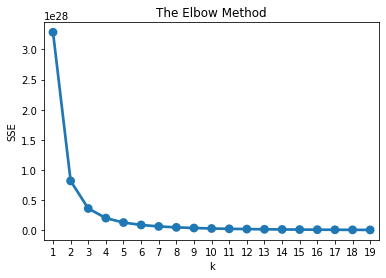

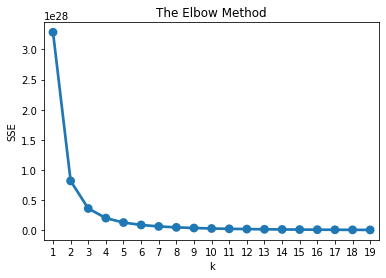

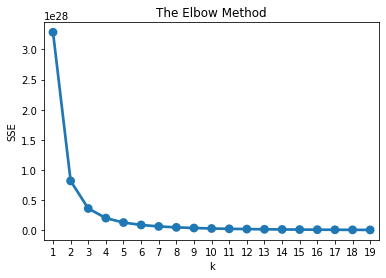

CPU times: user 27min 27s, sys: 8min 44s, total: 36min 12s
Wall time: 5min 12s


In [29]:
%%time
rec_df, freq_df, monet_df = rfm(hist_tran, name= 'historical')

In [31]:
rfm_hist = rfm_(rec_df, freq_df, monet_df, name= 'historical')
rfm_hist = reduce_mem_usage(rfm_hist)

Mem. usage decreased to 11.18 Mb (52.6% reduction)


In [64]:
rfm_hist.columns

Index(['card_id', 'historical_recency', 'historical_recency_cluster',
       'historical_frequency', 'historical_frequency_cluster',
       'historical_monetary', 'historical_monetary_cluster',
       'historical_RFMScore', 'historical_Membership'],
      dtype='object')

In [33]:
hist_tran = hist_tran.drop(['historical_recency'], axis = 1)

In [34]:
%%time
res = pd.get_dummies(hist_tran, columns = ['category_2', 'category_3'])

CPU times: user 4.35 s, sys: 1.66 s, total: 6.02 s
Wall time: 6.01 s


In [67]:
res.shape

(30472261, 43)

In [36]:
%%time
hist_tran = reduce_mem_usage(aggregated_transactional2(res,  name= 'historical'))

Mem. usage decreased to 12263.58 Mb (54.1% reduction)
CPU times: user 24min 38s, sys: 2min 30s, total: 27min 8s
Wall time: 27min 6s


In [37]:
hist_tran = hist_tran.drop(['purchase_date'], axis = 1)

In [38]:
hist_tran = reduce_mem_usage(hist_tran)

Mem. usage decreased to 12031.09 Mb (0.0% reduction)


In [39]:
hist_tran.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30472261 entries, 0 to 30472260
Columns: 170 entries, card_id to historical_active_months_lag12_median
dtypes: float16(77), float32(19), float64(12), int16(4), int64(2), int8(50), uint8(6)
memory usage: 11.7 GB


In [40]:
%%time
#Merging the created features with train set
train = train.merge( rfm_hist, on = 'card_id', how = 'left')

CPU times: user 101 ms, sys: 68 µs, total: 101 ms
Wall time: 101 ms


In [41]:
train.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 46 entries, first_active_month to historical_Membership
dtypes: float16(1), float32(2), float64(10), int16(2), int64(23), int8(4), object(1), uint8(3)
memory usage: 68.9 MB


In [42]:
%%time
train = reduce_mem_usage(pd.merge_asof(train, hist_tran, on = 'card_id'))

Mem. usage decreased to 94.16 Mb (30.0% reduction)
CPU times: user 33.9 s, sys: 5.05 s, total: 38.9 s
Wall time: 38.9 s


In [43]:
train.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 215 entries, first_active_month to historical_active_months_lag12_median
dtypes: float16(90), float32(19), float64(12), int16(14), int64(2), int8(68), object(1), uint8(9)
memory usage: 105.1 MB


In [44]:
#Merging the created features with train set
test = test.merge( rfm_hist, on = 'card_id', how = 'left')

In [45]:
%%time
test = reduce_mem_usage(pd.merge_asof(test, hist_tran, on = 'card_id'))

Mem. usage decreased to 53.88 Mb (34.4% reduction)
CPU times: user 26.8 s, sys: 5.29 s, total: 32.1 s
Wall time: 32.1 s


In [46]:
#test = reduce_mem_usage(test)

In [47]:
test.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 214 entries, first_active_month to historical_active_months_lag12_median
dtypes: float16(92), float32(22), float64(6), int16(14), int64(2), int8(68), object(1), uint8(9)
memory usage: 60.6 MB


In [48]:
import gc
del rfm_hist, hist_tran
gc.collect()

42

In [226]:
train.shape

(201917, 215)

In [227]:
test.shape

(123623, 214)

<h3> New Merchant Transactions Features </h3>

In [49]:
new_merch_tran = reduce_mem_usage(pd.merge(new_merch_tran, merch, on = 'merchant_id'))

Mem. usage decreased to 152.27 Mb (43.2% reduction)


In [50]:
new_merch_tran = transactional_features(new_merch_tran, name = 'new_merchants')

In [51]:
new_merch_tran = reduce_mem_usage(new_merch_tran)

Mem. usage decreased to 171.55 Mb (36.0% reduction)


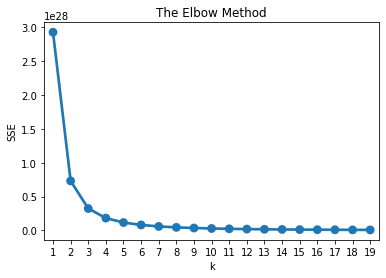

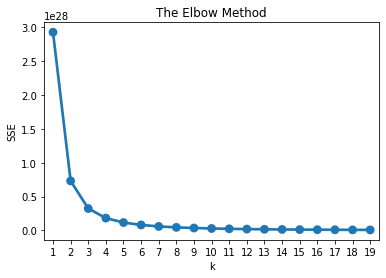

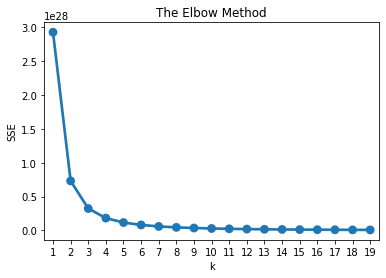

CPU times: user 27min 9s, sys: 8min 19s, total: 35min 29s
Wall time: 5min 1s


In [103]:
%%time
rec_df, freq_df, monet_df = rfm(new_merch_tran, name = 'new_merchants')

In [53]:
rfm_new_merch = rfm_(rec_df, freq_df, monet_df, name = 'new_merchants')
rfm_new_merch = reduce_mem_usage(rfm_new_merch)

Mem. usage decreased to  9.13 Mb (55.4% reduction)


In [86]:
new_merch_tran.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'new_merchants_purchase_month',
       'new_merchants_purchase_year', 'new_merchants_purchase_weekofyear',
       'new_merchants_purchase_dayofweek', 'new_merchants_purchase_weekend',
       'new_merchants_purchase_hour', 'new_merchants_month_diff',
       'new_merchants_purchase_time', 'new_merchants_recency'],
      dtype='object')

In [54]:
new_merch_tran = new_merch_tran.drop(['new_merchants_recency'], axis = 1)

In [55]:
%%time
res = pd.get_dummies(new_merch_tran, columns = ['category_2', 'category_3'])

CPU times: user 297 ms, sys: 80.2 ms, total: 377 ms
Wall time: 376 ms


In [56]:
%%time
new_merch_tran = reduce_mem_usage(aggregated_transactional3(res, name = 'new_merchants'))

Mem. usage decreased to 657.27 Mb (51.1% reduction)
CPU times: user 16min 7s, sys: 5.32 s, total: 16min 13s
Wall time: 16min 12s


In [57]:
new_merch_tran = new_merch_tran.drop(['purchase_date'], axis = 1)

In [58]:
new_merch_tran = reduce_mem_usage(new_merch_tran)

Mem. usage decreased to 641.85 Mb (0.0% reduction)


In [61]:
new_merch_tran.columns

Index(['card_id', 'purchase_date', 'new_merchants_purchase_month',
       'new_merchants_purchase_year', 'new_merchants_month_diff',
       'new_merchants_purchase_time', 'new_merchants_authorized_flag_sum',
       'new_merchants_authorized_flag_mean',
       'new_merchants_authorized_flag_min',
       'new_merchants_authorized_flag_max',
       ...
       'new_merchants_avg_purchases_lag12_mode',
       'new_merchants_avg_purchases_lag12_period',
       'new_merchants_avg_purchases_lag12_median',
       'new_merchants_active_months_lag12_sum',
       'new_merchants_active_months_lag12_mean',
       'new_merchants_active_months_lag12_max',
       'new_merchants_active_months_lag12_min',
       'new_merchants_active_months_lag12_mode',
       'new_merchants_active_months_lag12_period',
       'new_merchants_active_months_lag12_median'],
      dtype='object', length=171)

In [59]:
#Merging the created features with train set
train = train.merge( rfm_new_merch, on = 'card_id', how = 'left')

In [60]:
len(train.columns)

223

In [61]:
train = reduce_mem_usage(train)

Mem. usage decreased to 98.40 Mb (6.6% reduction)


In [62]:
%%time
train = reduce_mem_usage(pd.merge_asof(train, new_merch_tran, on = 'card_id'))

Mem. usage decreased to 159.44 Mb (0.0% reduction)
CPU times: user 6.03 s, sys: 172 ms, total: 6.21 s
Wall time: 6.2 s


In [63]:
train.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 392 entries, first_active_month to new_merchants_active_months_lag12_median
dtypes: float16(173), float32(40), float64(12), int16(16), int64(3), int8(123), object(2), uint8(23)
memory usage: 180.3 MB


In [64]:
#Merging the created features with train set
test = test.merge( rfm_new_merch, on = 'card_id', how = 'left')

In [65]:
%%time
test = reduce_mem_usage(pd.merge_asof(test, new_merch_tran, on = 'card_id'))

Mem. usage decreased to 93.85 Mb (4.3% reduction)
CPU times: user 4.39 s, sys: 124 ms, total: 4.51 s
Wall time: 4.51 s


In [67]:
test.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 391 entries, first_active_month to new_merchants_active_months_lag12_median
dtypes: float16(175), float32(43), float64(6), int16(16), int64(3), int8(123), object(2), uint8(23)
memory usage: 106.6 MB


In [68]:
del  rfm_new_merch, new_merch_tran
gc.collect()

21

<h2> Checking for infinity and null values </h2>

In [69]:
print("Train data has {} null values".format(train.isnull().sum().sum()))
print("Test data has {} null values".format(test.isnull().sum().sum()))

Train data has 175478 null values
Test data has 108888 null values


Lets check if any of them have infinity values

In [70]:
train2 = train.copy()
test2 = test.copy()

In [71]:
train2 = train2.drop(['historical_Membership', 'new_merchants_Membership'], axis = 1)
test2 = test2.drop(['historical_Membership', 'new_merchants_Membership'], axis = 1)

In [72]:
covMat = np.array(train2, dtype=float)
np.any(np.isinf(covMat))

True

In [73]:
covMat = np.array(test2, dtype=float)
np.any(np.isinf(covMat))

True

Since we had dropped the categorical variables in order to check if there are any infinity values. We will replace the infinity values with null values in the original train and test data set as they contain all features.

In [74]:
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

Now that we don't have any infinity values in data, lets just handle the missing values as we handled them previously. That is, replace with mode value if the datatype is object, and replace with median value if it is numeric value

In [75]:
nan_values = train.isna()
nan_columns = nan_values.any()

columns_with_nan = train.columns[nan_columns].tolist()
print(columns_with_nan)

['historical_avg_purchases_lag3_sum', 'historical_avg_purchases_lag3_mean', 'historical_avg_purchases_lag3_max', 'historical_avg_purchases_lag3_period', 'historical_avg_purchases_lag6_sum', 'historical_avg_purchases_lag6_mean', 'historical_avg_purchases_lag6_max', 'historical_avg_purchases_lag6_period', 'historical_avg_purchases_lag12_sum', 'historical_avg_purchases_lag12_mean', 'historical_avg_purchases_lag12_max', 'historical_avg_purchases_lag12_period', 'new_merchants_recency', 'new_merchants_recency_cluster', 'new_merchants_frequency', 'new_merchants_frequency_cluster', 'new_merchants_monetary', 'new_merchants_monetary_cluster', 'new_merchants_RFMScore', 'new_merchants_Membership']


In [76]:
nan_values = test.isna()
nan_columns = nan_values.any()

columns_with_nan = test.columns[nan_columns].tolist()
print(columns_with_nan)

['historical_avg_purchases_lag3_sum', 'historical_avg_purchases_lag3_mean', 'historical_avg_purchases_lag3_max', 'historical_avg_purchases_lag3_period', 'historical_avg_purchases_lag6_sum', 'historical_avg_purchases_lag6_mean', 'historical_avg_purchases_lag6_max', 'historical_avg_purchases_lag6_period', 'historical_avg_purchases_lag12_sum', 'historical_avg_purchases_lag12_mean', 'historical_avg_purchases_lag12_max', 'historical_avg_purchases_lag12_period', 'new_merchants_recency', 'new_merchants_recency_cluster', 'new_merchants_frequency', 'new_merchants_frequency_cluster', 'new_merchants_monetary', 'new_merchants_monetary_cluster', 'new_merchants_RFMScore', 'new_merchants_Membership']


In [77]:
print("Handing missing values in train data")
train = missing_value(train, columns_with_nan)
print("="*100)

print()
print("Handing missing values in test data")
test = missing_value(test, columns_with_nan)
print("="*100)

Handing missing values in train data
Successfully done!!!!

Handing missing values in test data
Successfully done!!!!


In [78]:
train.isnull().sum().sum()

0

In [79]:
test.isnull().sum().sum()

0

<h2> Feature Normalization </h2>

In [80]:
y_train = train['target'].values
y_train

array([ 0.134 ,  0.8843, -0.2644, ...,  1.53  , -0.6   , -1.073 ],
      dtype=float16)

In [81]:
train = train.drop(['target'], axis = 1)

In [82]:
X_train = train
X_test = test

In [83]:
num_features = [col for col in X_train.columns if X_train[col].dtype in ("uint8", "int8", "int16", "int32", "int64", "float16", "float32", "float64")]
cat_features=[col for col in X_train.columns if X_train[col].dtype=='object']

In [84]:
print(len(num_features))
print(len(cat_features))

389
2


In [85]:
print("NORMALIZING NUMERICAL FEATURES:")
for feature in num_features:
    print(feature)
    normalizer = Normalizer()
    train[feature] = normalizer.fit_transform(train[feature].values.reshape(-1, 1))
    test[feature] = normalizer.transform(test[feature].values.reshape(-1, 1))
    print(f" {feature} done ")
    print("="*127)
    
print()
print("NORMALIZING CATEGORICAL FEATURES:")
for feature in cat_features:
    vectorizer = CountVectorizer()
    train[feature] = vectorizer.fit_transform(train[feature].values).todense()
    test[feature] = vectorizer.transform(test[feature].values).todense()
    print(f"For {feature}, unique values are: ",vectorizer.get_feature_names_out())
    print("="*127)

NORMALIZING NUMERICAL FEATURES:
first_active_month
 first_active_month done 
card_id
 card_id done 
feature_1
 feature_1 done 
feature_2
 feature_2 done 
feature_3
 feature_3 done 
first_active_month_month
 first_active_month_month done 
first_active_month_year
 first_active_month_year done 
first_active_month_quarter
 first_active_month_quarter done 
first_active_diff_from_today
 first_active_diff_from_today done 
category_time_feature1
 category_time_feature1 done 
category_time_feature2
 category_time_feature2 done 
category_time_feature3
 category_time_feature3 done 
category_time_ratio1
 category_time_ratio1 done 
category_time_ratio2
 category_time_ratio2 done 
category_time_ratio3
 category_time_ratio3 done 
feature_1_days
 feature_1_days done 
feature_1_days_ratio
 feature_1_days_ratio done 
feature_2_days
 feature_2_days done 
feature_2_days_ratio
 feature_2_days_ratio done 
feature_3_days
 feature_3_days done 
feature_3_days_ratio
 feature_3_days_ratio done 
first_active_mont

<h2> Evaluation Metric </h2>
Sklearn doesn't have built-in RMSE library, so we will build a custom function

In [86]:
y_train_copy = y_train.copy()

In [87]:
def RMSE(y_true, y_pred):
    """Root mean squared error regression loss"""
    return np.sqrt(np.mean(np.square(y_true-y_pred)))

my_scorer = make_scorer(RMSE, greater_is_better=False)

<h2> Feature Selection </h2>

parameters values are taken through reference : https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending

In [117]:
feat = X_train.columns
feature_importance = pd.DataFrame()


folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=5)
oof_1 = np.zeros(X_train.shape[0])
test_predictions_1 = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[feat], y_train)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train[feat].iloc[trn_idx],
                          label=y_train[trn_idx],
                          )
    val_data = lgb.Dataset(X_train[feat].iloc[val_idx],
                          label=y_train[val_idx],
                          )
    params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
            }

    clf = lgb.train( params,
                     trn_data,
                     10000,
                     valid_sets = [trn_data, val_data],
                     verbose_eval=500,
                     early_stopping_rounds = 200,
                   )

    oof_1[val_idx] = clf.predict(X_train[feat].iloc[val_idx],
                              num_iteration=clf.best_iteration)

    test_predictions_1 += clf.predict(test, num_iteration=clf.best_iteration) / (5*2)
 
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feat
    fold_importance["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0) 

fold n°0
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.7345	valid_1's rmse: 3.83304
Early stopping, best iteration is:
[717]	training's rmse: 3.71626	valid_1's rmse: 3.83151
fold n°1
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.72755	valid_1's rmse: 3.86521
[1000]	training's rmse: 3.69448	valid_1's rmse: 3.86262
Early stopping, best iteration is:
[1025]	training's rmse: 3.69424	valid_1's rmse: 3.86261
fold n°2
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.73748	valid_1's rmse: 3.82954
[1000]	training's rmse: 3.70669	valid_1's rmse: 3.8234
[1500]	training's rmse: 3.70646	valid_1's rmse: 3.82336
Early stopping, best iteration is:
[1350]	training's rmse: 3.70646	valid_1's rmse: 3.82336
fold n°3
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.77086	valid_1's rmse: 3.68572
[1000]	training's rmse: 3.73716	valid_1's rmse: 3.68367
Ea

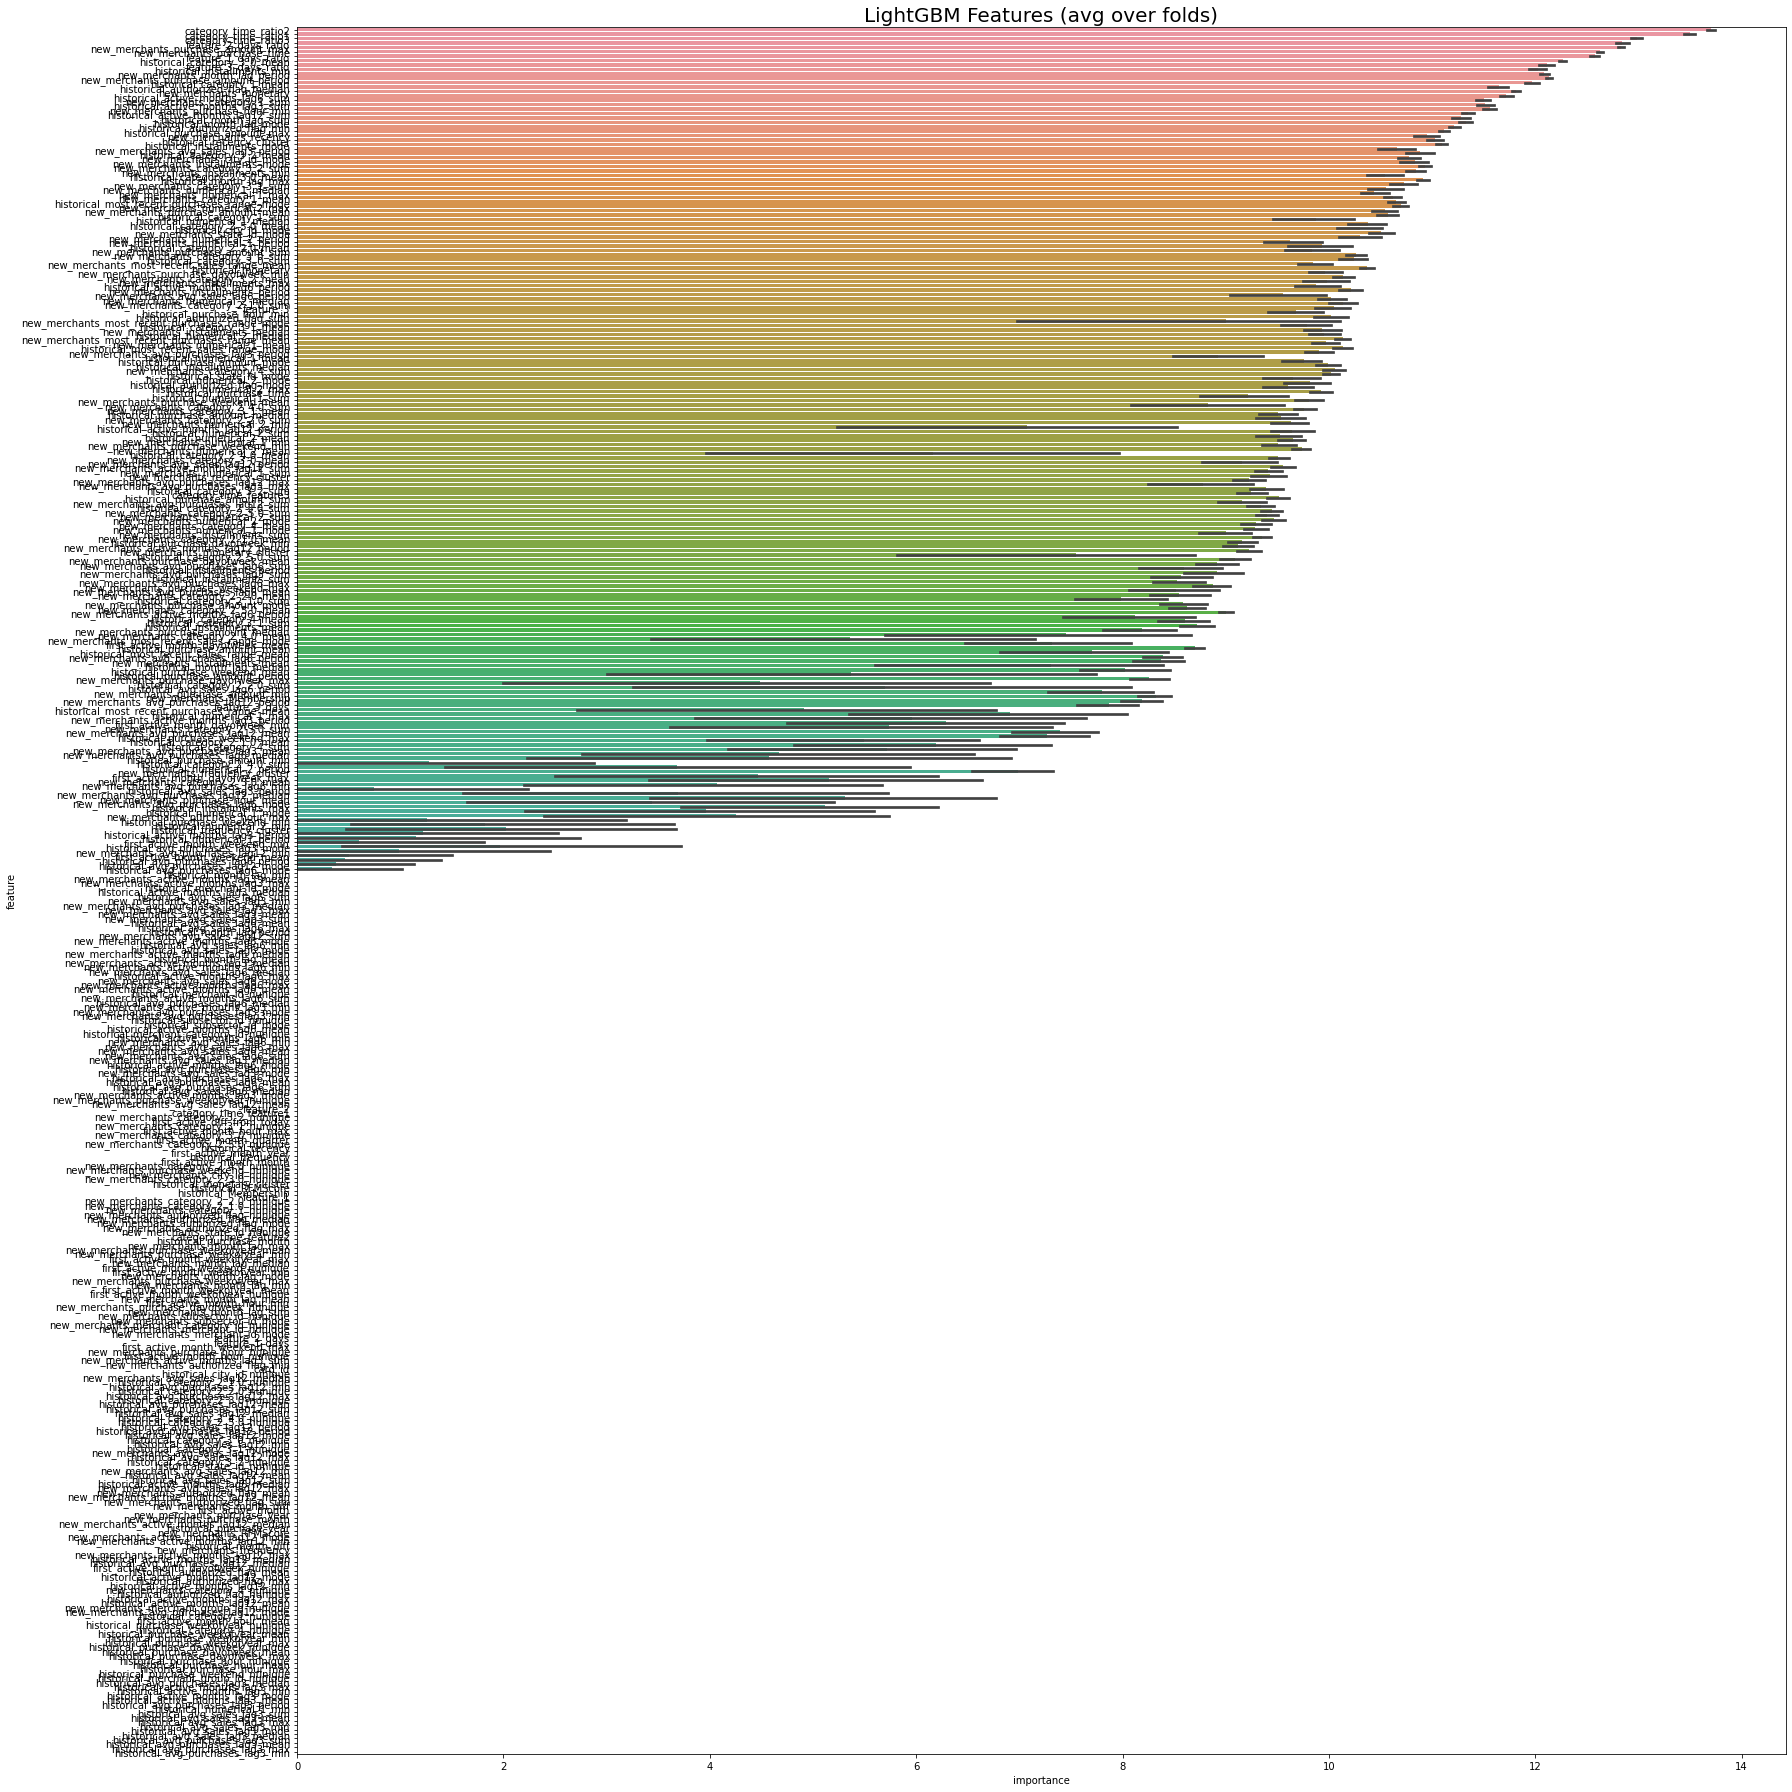

In [118]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:].index
imp_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(25, 25))
ax = sns.barplot(x="importance", y="feature", data=imp_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)', fontsize = 20)
plt.tight_layout()

In [136]:
data = imp_features.sort_values(by="importance", ascending=False)
data = data[data['importance']>0.000]
selected_features = data['feature'].unique()

In [137]:
len(selected_features)

191

In [138]:
x_train = X_train[np.intersect1d(X_train.columns, selected_features)]
x_test = X_test[np.intersect1d(X_test.columns, selected_features)]

In [90]:
len(data['feature'].unique())

191

In [95]:
x_train.shape

(201917, 191)

In [ ]:
x_train.to_csv("x_train.csv")
x_test.to_csv("x_test.csv")
y_train = pd.DataFrame(y_train, columns = ['target'])
y_train.to_csv("y_train.csv")

In [3]:
x_train = pd.read_csv("x_train.csv", index_col = 0)
x_test = pd.read_csv("x_test.csv", index_col = 0)
y_train = pd.read_csv("y_train.csv", index_col = 0)

In [4]:
y_train = y_train.values

<h2> Modeling </h2>
<h3>1. Baseline Model </h3>

In [8]:
RMSE(y_train, np.mean(y_train))

3.8505558749087045

<h2> 2. Light Gradient Boosting Model </h2>

In [9]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

def lgbm_(
            num_leaves, 
            learning_rate,
            colsample_bytree, 
            subsample,
            max_depth,
            reg_alpha,
            reg_lambda,
            min_split_gain,
            min_child_weight,
            min_data_in_leaf,
            min_child_samples,
            feature_fraction,
            bagging_freq,
            bagging_fraction,
            n_estimators
         ):
    params = dict()
    params["verbose"] = -1
    params["metric"] = "rmse"
    params["objective"] = "regression"
    params["learning_rate"] = learning_rate
    params["num_leaves"] = int(num_leaves)
    params["colsample_bytree"] = max(min(colsample_bytree, 1), 0)
    params["subsample"] = max(min(subsample, 1), 0)
    params["max_depth"] = int(max_depth)
    params["reg_alpha"] = max(reg_alpha, 0)
    params["reg_lambda"] = max(reg_lambda, 0)
    params["min_split_gain"] = min_split_gain
    params["min_child_weight"] = min_child_weight
    params["min_data_in_leaf"] = int(min_data_in_leaf)
    params["min_child_samples"] = min_child_samples
    params["feature_fraction"] = feature_fraction
    params["bagging_freq"] = int(bagging_freq)
    params["bagging_fraction"] = bagging_fraction
    params["n_estimators"] = int(n_estimators)


    folds = KFold(n_splits=9, shuffle=True, random_state=245)
    out_of_fold = np.zeros(len(x_train))   #out of fold
    features = x_train.columns
    print(len(features))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(x_train.iloc[trn_idx][features], label=y_train[trn_idx])#, categorical_feature=categorical_feats

        val_data = lgb.Dataset(x_train.iloc[val_idx][features], label=y_train[val_idx])#, categorical_feature=categorical_feats


        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 120)
    
        out_of_fold[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    return mean_squared_error(out_of_fold, y_train)**0.5



CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 17.4 µs


In [10]:
bo = BayesianOptimization(lgbm_, {
                                    "num_leaves" : (16, 28), 
                                    "learning_rate":(0.0001, 0.1),
                                    "colsample_bytree" : (0.1, 0.9), 
                                    "subsample" : (0.1, 1),
                                    "max_depth" : (6, 20),
                                    "reg_alpha" : (0, 10),
                                    "reg_lambda" : (0, 10),
                                    "min_split_gain" : (0, 1),
                                    "min_child_weight" : (45, 60),
                                    "min_data_in_leaf" : (10, 50),
                                    "min_child_samples" : (5, 40),
                                    "feature_fraction" : (0.8, 0.9),
                                    "bagging_freq" : (1, 50),
                                    "bagging_fraction" : (0.8, 0.99),
                                    "n_estimators" : (10, 900)
                                    }
                         )

In [13]:
%%time

print('-'*126)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    bo.maximize(init_points=1, n_iter=3, acq='ei', xi=0.0)

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_ch... | min_da... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
191
fold n°0
[LightGBM] [Warning] bagging_fraction is set=0.8529641384538201, subsample=0.2891420383963445 will be ignored. Current value: bagging_fraction=0.8529641384538201
[LightGBM] [Warning] feature_fraction is set=0.809912886764847, colsample_bytree=0.47180558077308143 will be ignored. Current value: feature_fraction=0.809912886764847
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=10.752977820967425 will be ignored. Current value: 

In [14]:
optimized_parameters = bo.max
print(optimized_parameters['params'])

{'bagging_fraction': 0.8529641384538201, 'bagging_freq': 23.103664075744963, 'colsample_bytree': 0.47180558077308143, 'feature_fraction': 0.809912886764847, 'learning_rate': 0.011641410157069463, 'max_depth': 10.543835033788199, 'min_child_samples': 10.752977820967425, 'min_child_weight': 56.38257329106763, 'min_data_in_leaf': 40.65917472066798, 'min_split_gain': 0.28540150321666347, 'n_estimators': 631.2299091325161, 'num_leaves': 21.691539213158805, 'reg_alpha': 1.1759966316113246, 'reg_lambda': 7.613994190852516, 'subsample': 0.2891420383963445}


In [15]:
#Training with best parameters
warnings.simplefilter(action='ignore', category=FutureWarning)

folds = KFold(n_splits=9, shuffle=True, random_state=245)
out_of_folds = np.zeros(len(x_train))   #out of fold

test_predictions = np.zeros(len(x_test))
features = x_train.columns
    
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features], label=y_train[trn_idx])

    val_data = lgb.Dataset(x_train.iloc[val_idx][features], label=y_train[val_idx])

    params = {
              "verbose" : -1,
              'objective': 'regression',
              'metric': 'rmse',
              'bagging_fraction':  0.8529641384538201, 
              'bagging_freq': 23, 
              'colsample_bytree': 0.47180558077308143, 
              'feature_fraction': 0.809912886764847, 
              'learning_rate': 0.011641410157069463, 
              'max_depth': 11, 
              'min_child_samples': 10.752977820967425, 
              'min_child_weight': 56.38257329106763, 
              'min_data_in_leaf': 41,
              'min_split_gain': 0.28540150321666347, 
              'n_estimators': 631,
              'num_leaves': 22, 
              'reg_alpha': 1.1759966316113246, 
              'reg_lambda': 7.613994190852516, 
              'subsample': 0.2891420383963445
    }
    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 120)
    
    out_of_folds[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

fold n°0
[LightGBM] [Warning] feature_fraction is set=0.809912886764847, colsample_bytree=0.47180558077308143 will be ignored. Current value: feature_fraction=0.809912886764847
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=10.752977820967425 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.8529641384538201, subsample=0.2891420383963445 will be ignored. Current value: bagging_fraction=0.8529641384538201
Training until validation scores don't improve for 120 rounds
[100]	training's rmse: 3.8088	valid_1's rmse: 3.86585
[200]	training's rmse: 3.79031	valid_1's rmse: 3.85389
[300]	training's rmse: 3.77785	valid_1's rmse: 3.84772
[400]	training's rmse: 3.76731	valid_1's rmse: 3.84382
[500]	training's rmse: 3.75845	valid_1's rmse: 3.84062
[600]	training's rmse: 3.75074	valid_1's rmse: 3.83847
Did not meet early stopping. Best iteration is:
[631]	training's rmse: 3.74872	valid_1's rmse: 3.83844
fold n°1
[LightGBM] [Warning]

In [16]:
rmse = np.sqrt(mean_squared_error(y_train, out_of_folds))
print("Final RMSE on train data: {:2.5f}".format(rmse))

Final RMSE on train data: 3.79634


<h2>3. CatBoost Model </h2>

In [4]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

def CB_Opt(
            num_leaves, 
            learning_rate,
            subsample,
            depth,
            l2_leaf_reg,
            n_estimators
         ):
    score = 0
    y_preds = 0
    folds = KFold(n_splits=10, shuffle=True, random_state=245)
    CB_oof = np.zeros(len(x_train))   #out of fold
    features = [f for f in x_train.columns if f not in ['target', 'card_id', 'first_active_month']]

    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train)):
        print("fold n°{}".format(fold_))
        x_tr, x_val = x_train.iloc[trn_idx][features], x_train.iloc[val_idx][features]#.values.tolist()
        y_tr, y_val = y_train[trn_idx], y_train[val_idx]
        clf= CatBoostRegressor(verbose = 0,
                            n_estimators = int(n_estimators),
                            learning_rate = learning_rate,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            subsample = max(min(subsample, 1), 0), 
                            l2_leaf_reg = l2_leaf_reg,
                            depth = int(depth),
                            grow_policy = "Lossguide",
                            num_leaves = int(num_leaves),
                            random_state = 88,
                            use_best_model = True, 
                            )
    
        fit_model = clf.fit( x_tr, y_tr, 
                               eval_set=(x_val, y_val),
                               use_best_model=True,
                              early_stopping_rounds=120
                             )

        cb_oof = clf.predict(x_val)

        print(f"Fold {fold_ + 1} | RMSE: {mean_squared_error(y_val, cb_oof)**0.5}")   
        score += mean_squared_error(y_val, cb_oof) / 10
        y_preds += clf.predict(x_train)/ 10 

    print(f"\nMean RMSE = {score}")
    print(f"Out of folds RMSE = {mean_squared_error(y_train, y_preds)**0.5}")
    
    return mean_squared_error(CB_oof, y_train)**0.5

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 25.5 µs


In [5]:
CB_bo = BayesianOptimization(CB_Opt, {
                                    "num_leaves" : (16, 50), 
                                    "learning_rate":(0.0001, 0.1),
                                    "l2_leaf_reg" : (0, 10),
                                    "subsample" : (0.1, 1),
                                    "depth" : (4, 6),
                                    "n_estimators" : (10, 900)
                                    }
                             )

In [6]:
%%time
from catboost import CatBoostRegressor
print('-'*126)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    CB_bo.maximize(init_points=1, n_iter=5, acq='ei', xi=0.0)

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   |   depth   | l2_lea... | learni... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
fold n°0
Fold 1 | RMSE: 3.8418283203691304
fold n°1
Fold 2 | RMSE: 3.946271498040029
fold n°2
Fold 3 | RMSE: 3.796190986816119
fold n°3
Fold 4 | RMSE: 3.9539351261007796
fold n°4
Fold 5 | RMSE: 3.662323536928242
fold n°5
Fold 6 | RMSE: 3.740573736424589
fold n°6
Fold 7 | RMSE: 3.7647035360161225
fold n°7
Fold 8 | RMSE: 3.7984221246688112
fold n°8
Fold 9 | RMSE: 3.7903932186809235
fold n°9
Fold 10 | RMSE: 3.712991670797369

Mean RMSE = 14.453626938689771
Out of folds RMSE = 3.778146409235977
|  1        |  3.871    |  4.248    |  0.1068   |  0.01604  |  573.4    |  37.22    |  0.9322   |
fold n°0
Fold 1 | RMSE: 3.841517604610177
fold n°1
Fold 2 | RMSE: 3.945545032848625

In [7]:
optimized_parameters = CB_bo.max
print(optimized_parameters['params'])

{'depth': 4.247696082422892, 'l2_leaf_reg': 0.10675190782459043, 'learning_rate': 0.016041515771099524, 'n_estimators': 573.4447480270032, 'num_leaves': 37.22020257284667, 'subsample': 0.9321882178273556}


In [8]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

score = 0
y_preds = 0
folds = KFold(n_splits=10, shuffle=True, random_state=245)
CB_oof = np.zeros(len(x_train))   #out of fold
features = [f for f in x_train.columns if f not in ['target', 'card_id', 'first_active_month']]

    
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train)):
        print("fold n°{}".format(fold_))
        x_tr, x_val = x_train.iloc[trn_idx][features], x_train.iloc[val_idx][features]#.values.tolist()
        y_tr, y_val = y_train[trn_idx], y_train[val_idx]
        clf= CatBoostRegressor(verbose = 0,
                            n_estimators = 573,
                            learning_rate = 0.016041515771099524,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            subsample = 0.9321882178273556, 
                            l2_leaf_reg = 0.10675190782459043,
                            depth = 4,
                            grow_policy = "Lossguide",
                            num_leaves = 37
                            )
    
        fit_model = clf.fit( x_tr, y_tr, 
                               eval_set=(x_val, y_val),
                               use_best_model=True,
                            early_stopping_rounds=120
                             )

        cb_oof = clf.predict(x_val)
        print(f"Fold {fold_ + 1} | RMSE: {mean_squared_error(y_val, cb_oof)**0.5}")   
        score += mean_squared_error(y_val, cb_oof) / 10
        y_preds += clf.predict(x_train)/ 10 

print(f"\nMean RMSE = {score}")
print(f"Out of folds RMSE = {mean_squared_error(y_train, y_preds)**0.5}")    

fold n°0
Fold 1 | RMSE: 3.840973860122841
fold n°1
Fold 2 | RMSE: 3.9453745488220933
fold n°2
Fold 3 | RMSE: 3.7959140444527066
fold n°3
Fold 4 | RMSE: 3.9530611956831505
fold n°4
Fold 5 | RMSE: 3.6628266920428665
fold n°5
Fold 6 | RMSE: 3.7413047054314927
fold n°6
Fold 7 | RMSE: 3.763640535285741
fold n°7
Fold 8 | RMSE: 3.7981597772322315
fold n°8
Fold 9 | RMSE: 3.789675760334345
fold n°9
Fold 10 | RMSE: 3.7125914182313453

Mean RMSE = 14.450436222857629
Out of folds RMSE = 3.7778556652427424
CPU times: user 43min 28s, sys: 1min 12s, total: 44min 41s
Wall time: 6min 41s


In [9]:
rmse = np.sqrt(mean_squared_error(y_train, y_preds))
print("Final RMSE on train data: {:2.5f}".format(rmse))

Final RMSE on train data: 3.77786


<h2> Second Approach </h2>

Inspired by the approach given by [Evgeny Patekha](https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/82314) kernal. I will attempt to implement his idea. I took reference for this implementation through [Rajat Malviya](https://github.com/Rjt5412/Elo-Merchant-Category-Recommendation/tree/main/Models)

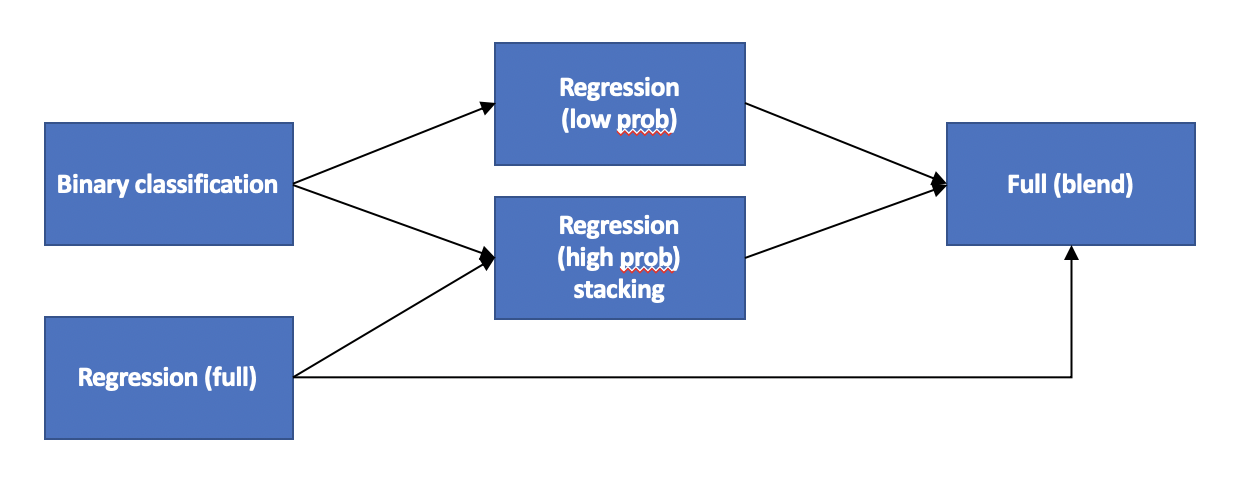

In [3]:
from IPython.display import Image
Image(filename='Elo_solution_schema.png')

1. Regression of full data set - This was a simple regression model that was trained on the complete dataset. The whole data was used to train an LGBM model using Repeated K Fold.

2. Binary Classification model - This classification model discovers outlier points using a binary classification technique. This model was an LGBM Classifier. Based on the class probabilities provided from the model, a threshold (hyper parameter) was used to categorise the card/user as an infrequent data point (outlier).

3. Low Probability Model - Regression model trained on infrequent data points with a low concentration (hyperparameter) (outliers). The LGBM regressor model was also trained on all characteristics.

4. High Probability Model - Outliers with a high concentration (hyperparameter) were used to train the regression model. Because we have a small number of infrequent data points, the model is prone to overfitting. As a result, this was a straightforward regression model (Bayesian Ridge Regression). For training, the predictions from the Full Regression model and Binary Classification were employed.

5. Final Blend - The predictions from the high-probability model, the low-probability model, and the full regression model were combined to provide a final prediction of the loyalty score. The final meta-model here was also a Bayesian regression model.

<h2> Data Prep </h2>

<h2> Adding outliers column </h2>

In [132]:
X_train = X_train.drop(['outliers'], axis =1)

In [104]:
X_train.shape

(201917, 390)

In [106]:
X_test.shape

(123623, 390)

In [257]:
X_train = X_train.merge(train_ids, left_index = True, right_index = True)
X_test = X_test.merge(test_ids, left_index = True, right_index = True)

In [130]:
X_train.shape

(201917, 392)

In [109]:
X_test.shape

(123623, 391)

In [254]:
dummy_y_train = y_train.copy()

In [135]:
dummy_y_train = pd.DataFrame(dummy_y_train, columns=['target'])

In [258]:
dummy_y_train = dummy_y_train.merge(X_train['card_id'], left_index = True, right_index = True)
dummy_y_train.shape

(201917, 2)

In [259]:
dummy_y_train

,target,card_id
0,0.134033,92a2005557
1,0.884277,3d0044924f
2,-0.264404,d639edf6cd
3,0.812988,186d6a6901
4,1.288086,cdbd2c0db2
...,...,...
201912,0.363037,963962de2c
201913,-0.085327,1314773c0b
201914,1.530273,7666735b3d
201915,-0.600098,73f5a0efd0


In [260]:
dummy_y_train['outliers'] = 0
dummy_y_train.loc[dummy_y_train['target']<-30, 'outliers'] = 1

In [261]:
dummy_y_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [262]:
outliers.outliers.value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [263]:
outliers = dummy_y_train[['card_id', 'outliers']]
X_train = X_train.merge(outliers, on = 'card_id', how = 'left')

In [264]:
X_train.outliers.value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [143]:
X_train.shape

(201917, 392)

In [123]:
X_test.shape

(123623, 391)

<h2> Regression on Full Dataset </h2>

In [144]:
columns = X_train.columns
columns = columns.drop('outliers')

<h2> Repeated K Fold LGBM </h2>

In [146]:
#Reference: https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

folds =RepeatedKFold(n_splits=10, n_repeats=3, random_state=5)
out_of_folds = np.zeros(len(X_train))   #out of fold
print(X_test.shape[1])
test_predictions = np.zeros(len(X_test))
features = [f for f in X_train.columns if f not in ['card_id', 'outliers']]
    
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[features], y_train)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train[features].iloc[trn_idx],
                          label=y_train[trn_idx],
                          )
    val_data = lgb.Dataset(X_train[features].iloc[val_idx],
                          label=y_train[val_idx],
                          )

    params = {
                "verbose" : -1,               
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                                    }
    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    out_of_folds[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    test_predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / (10*3)

392
fold n°0
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.74851	valid_1's rmse: 3.79421
[1000]	training's rmse: 3.71738	valid_1's rmse: 3.7902
Early stopping, best iteration is:
[815]	training's rmse: 3.72591	valid_1's rmse: 3.79008
fold n°1
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.73868	valid_1's rmse: 3.87003
Early stopping, best iteration is:
[597]	training's rmse: 3.72869	valid_1's rmse: 3.86955
fold n°2
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.73982	valid_1's rmse: 3.87517
[1000]	training's rmse: 3.7071	valid_1's rmse: 3.87162
Early stopping, best iteration is:
[974]	training's rmse: 3.70799	valid_1's rmse: 3.8715
fold n°3
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.74157	valid_1's rmse: 3.85334
[1000]	training's rmse: 3.70955	valid_1's rmse: 3.85042
Early stopping, best iteration is:
[947]	training's rmse:

In [148]:
rmse = RMSE(y_train, out_of_folds)
print("Final RMSE on data: {:2.5f}".format(rmse))

Final RMSE on data: 3.79368


In [150]:
train_prediction = pd.DataFrame()
test_prediction = pd.DataFrame()

train_prediction['card_id'] = train_ids
train_prediction['train_full_regression'] = out_of_folds
test_prediction['card_id'] = test_ids
test_prediction['test_full_regression'] = test_predictions

In [151]:
train_prediction.to_csv('train_full_regression.csv')
test_prediction.to_csv('test_full_regression.csv')

In [152]:
test_prediction.shape

(123623, 2)

<h2> Model 2 - Binary Classification Model </h2>

In [153]:
y_data = dummy_y_train['outliers']

In [154]:
y_data.value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [157]:
X_train.outliers.value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [159]:
def lgbm_(
            num_leaves,
            colsample_bytree,
            max_depth,
            n_estimators,
            subsample,
            learning_rate,
            reg_alpha,
            reg_lambda,


):

  folds = StratifiedKFold(n_splits = 3, shuffle=True, random_state=2)
  out_of_folds = np.zeros(X_train.shape[0])
  features = [f for f in X_train.columns if f not in ['card_id', 'outliers']]

  for fold_, (train_idx, val_idx) in enumerate(folds.split(X_train[features], y_data)):
    print("Fold:", fold_)
    trn_data = lgb.Dataset(X_train[features].iloc[train_idx], label = y_data.iloc[train_idx])
    val_data = lgb.Dataset(X_train[features].iloc[val_idx], label = y_data.iloc[val_idx])


    param = dict()
    param['task'] = 'train'
    param['boosting_type'] = 'goss'
    param["verbose"] = -1
    param["metric"] = "binary_logloss"
    param["objective"] = "binary"
    param['is_unbalance'] = True
    param["num_leaves"] = int(num_leaves)
    param["colsample_bytree"] = max(min(colsample_bytree, 1), 0)
    param["subsample"] = max(min(subsample, 1), 0)
    param["max_depth"] = int(max_depth)
    param["reg_alpha"] = max(reg_alpha, 0)
    param["reg_lambda"] = max(reg_lambda, 0)
    param["n_estimators"] = int(n_estimators)
    param['learning_rate'] = learning_rate

    clf = lgb.train(param,
                    trn_data,
                    valid_sets = [trn_data, val_data],
                    verbose_eval = 10000,
                    early_stopping_rounds = 200
                    )
    
    out_of_folds[val_idx] = clf.predict(X_train[features].iloc[val_idx])
  
  return -log_loss(y_data, out_of_folds)

In [201]:
bo = BayesianOptimization(lgbm_, {
                                    "num_leaves" : (10, 500),                 
                                    "colsample_bytree" : (0.1, 1),
                                    "subsample" : (0.1, 1), 
                                    "max_depth" : (6, 90), 
                                    "reg_alpha" : (0, 1), 
                                    "reg_lambda" : (0, 1), 
                                    "learning_rate" : (0.0001, 0.1),                        
                                    "n_estimators" : (10, 900) 
                                    }
                         )

In [202]:
%%time

print('-'*126)

#start_time = timer(None)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    bo.maximize(init_points=1, n_iter=2, acq='ei', xi=0.0)
#timer(start_time)

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
Fold: 0
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0502596	valid_1's binary_logloss: 0.0521197
Fold: 1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0503414	valid_1's binary_logloss: 0.0520423
Fold: 2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.050333	valid_1's binary_logloss: 0.0519773
|  1        | -0.05205  |  0.2186   |  0.003239 |  40.73    |  505.2    |  260.0 

In [203]:
print('Final Results')
print('Best  parameters: ', bo.max['params'])

Final Results
Best  parameters:  {'colsample_bytree': 0.6245126460081392, 'learning_rate': 0.0401080564194141, 'max_depth': 16.96807065749421, 'n_estimators': 592.0704353714351, 'num_leaves': 484.2241231106072, 'reg_alpha': 0.05567863048240196, 'reg_lambda': 0.5198371176982832, 'subsample': 0.7547010645237946}


<h2> Training with best parameters </h2>

In [204]:
params = {'colsample_bytree': 0.6245126460081392, 'learning_rate': 0.0401080564194141, 'max_depth': 17, 'n_estimators': 592, 'num_leaves': 484, 'reg_alpha': 0.05567863048240196, 'reg_lambda': 0.5198371176982832, 'subsample': 0.7547010645237946,
          'verbose' : -1
         }

In [205]:
trn_data = lgb.Dataset(X_train[features], label = y_data)

clf = lgb.train(params,
                trn_data,
                100000,
                verbose_eval=100
                )

In [206]:
train_preds = clf.predict(X_train[features])

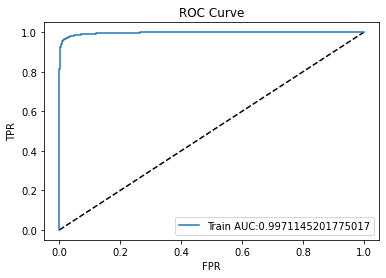

In [207]:
plt.plot([0,1],[0,1], 'k--')


#Train AUC
fpr, tpr, threshold = roc_curve(y_data, train_preds)
auc_score = roc_auc_score(y_data, train_preds)
plt.plot(fpr, tpr, label="Train AUC:"+str(auc_score))


plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

In [208]:
with open('Binary_Classification_model.pkl', 'wb') as f:
  pickle.dump(clf, f)

In [209]:
#Load the model

with open('Binary_Classification_model.pkl', 'rb') as f:
  clf = pickle.load(f)

Prob predictions for actual test data:

In [210]:
features2 = [f for f in X_train.columns if f not in ['card_id']]
train_probabilities = clf.predict(X_train[features])
test_probabilities = clf.predict(X_test[features])

threshold = 0.03

train_labels = np.where(train_probabilities > threshold, 1, 0)
test_labels = np.where(test_probabilities > threshold, 1, 0)

In [211]:
# Check accuracy on the train data

print("Accuracy on entire train data:", accuracy_score(train_labels, y_data))

Accuracy on entire train data: 0.9145391423208546


In [212]:
# Saving our predictions for further use
with open('train_prob_labels.pkl', 'wb') as f:
  pickle.dump(train_probabilities, f)

with open('test_prob_labels.pkl', 'wb') as f:
  pickle.dump(test_probabilities, f)

In [213]:
# Saving our predictions for further use
with open('train_predicted_labels.pkl', 'wb') as f:
  pickle.dump(train_labels, f)

with open('test_predicted_labels.pkl', 'wb') as f:
  pickle.dump(test_labels, f)

<h2> Model 3 - Low Probability Model </h2>
<h2> Data Prep </h2>

In [214]:
## Load the predicted labels from Binary Classification Model

with open('train_predicted_labels.pkl','rb') as f:
    train_labels = pickle.load(f)

with open('test_predicted_labels.pkl','rb') as f:
    test_labels = pickle.load(f)


with open('train_prob_labels.pkl', 'rb') as f:
    train_prob = pickle.load(f)

with open('test_prob_labels.pkl', 'rb') as f:
    test_prob = pickle.load(f)

In [266]:
X_train['outlier_probability'] = train_prob
X_train['outlier_prediction'] = train_labels
X_test['outlier_probability'] = test_prob
X_test['outlier_prediction'] = test_labels

In [267]:
train_card_ids = train_ids
test_card_ids = test_ids
train_target = y_train

<h2> Low Probability Model </h2>

In [251]:
y_train = pd.DataFrame(y_train, columns=['target'])
X_train = X_train.merge(y_train, left_index = True, right_index = True)
X_train.shape

(201917, 391)

In [268]:
X_train.columns

Index(['first_active_month', 'feature_1', 'feature_2', 'feature_3',
       'first_active_month_month', 'first_active_month_year',
       'first_active_month_quarter', 'first_active_diff_from_today',
       'category_time_feature1', 'category_time_feature2',
       ...
       'new_merchants_active_months_lag12_max',
       'new_merchants_active_months_lag12_min',
       'new_merchants_active_months_lag12_mode',
       'new_merchants_active_months_lag12_period',
       'new_merchants_active_months_lag12_median', 'target', 'card_id',
       'outliers', 'outlier_probability', 'outlier_prediction'],
      dtype='object', length=395)

In [269]:
X_train.outlier_prediction.value_counts()

0    182496
1     19421
Name: outlier_prediction, dtype: int64

In [270]:
X_test.shape

(123623, 393)

In [272]:
# condition mask
mask = X_train['outlier_prediction'] == 0 #predicted as outliers
  
# new dataframe with selected rows
low_probability_data = pd.DataFrame(X_train[mask])
low_probability_data.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182496 entries, 0 to 201916
Columns: 395 entries, first_active_month to outlier_prediction
dtypes: float16(173), float32(40), float64(177), int64(4), object(1)
memory usage: 353.1 MB


In [273]:
# condition mask
mask = X_train['outliers'] == 1
  
infrequent_outliers = low_probability_data[mask] #actual outliers present in predicted outliers
infrequent_outliers.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 7713 to 199064
Columns: 395 entries, first_active_month to outlier_prediction
dtypes: float16(173), float32(40), float64(177), int64(4), object(1)
memory usage: 41.6 KB


In [274]:
# condition mask
mask = low_probability_data['outliers'] == 0
  
low_probability_data = low_probability_data[mask] #actual outliers present in predicted outliers
low_probability_data.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182475 entries, 0 to 201916
Columns: 395 entries, first_active_month to outlier_prediction
dtypes: float16(173), float32(40), float64(177), int64(4), object(1)
memory usage: 353.1 MB


In [275]:
infrequent_outliers = infrequent_outliers.sample(10)
low_probability_data = pd.concat([low_probability_data, infrequent_outliers], ignore_index=True)

In [276]:
y_low_prob = low_probability_data['target']
low_prob_card_ids = low_probability_data['card_id']
low_probability_data.drop(columns=['card_id', 'target', 'outliers', 'outlier_prediction', 'outlier_probability'], axis=1, inplace=True)

In [292]:
low_probability_data.drop(columns=['target'], axis=1, inplace=True)

In [277]:
X_test.columns

Index(['first_active_month', 'feature_1', 'feature_2', 'feature_3',
       'first_active_month_month', 'first_active_month_year',
       'first_active_month_quarter', 'first_active_diff_from_today',
       'category_time_feature1', 'category_time_feature2',
       ...
       'new_merchants_active_months_lag12_sum',
       'new_merchants_active_months_lag12_mean',
       'new_merchants_active_months_lag12_max',
       'new_merchants_active_months_lag12_min',
       'new_merchants_active_months_lag12_mode',
       'new_merchants_active_months_lag12_period',
       'new_merchants_active_months_lag12_median', 'card_id',
       'outlier_probability', 'outlier_prediction'],
      dtype='object', length=393)

In [278]:
X_train.drop(columns=[ 'card_id', 'target', 'outliers', 'outlier_prediction', 'outlier_probability'], axis=1, inplace=True)
X_test.drop(columns=[ 'card_id', 'outlier_prediction', 'outlier_probability'], axis=1, inplace=True)

In [293]:
X_train = X_train.drop([], axis = 1)

In [294]:
low_probability_data.reset_index(drop=True, inplace=True)

In [295]:
low_probability_data.shape

(182485, 390)

<h2> LGBM Model </h2>

In [296]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

def lgbm_(
            num_leaves, 
            learning_rate,
            colsample_bytree, 
            subsample,
            max_depth,
            reg_alpha,
            reg_lambda,
            min_split_gain,
            min_child_weight,
            min_data_in_leaf,
            min_child_samples,
            feature_fraction,
            bagging_freq,
            bagging_fraction,
            n_estimators
         ):
    params = dict()
    params["verbose"] = -1
    params["metric"] = "rmse"
    params["objective"] = "regression"
    params["boosting"] = "gbdt",
    params["learning_rate"] = learning_rate
    params["num_leaves"] = int(num_leaves)
    params["colsample_bytree"] = max(min(colsample_bytree, 1), 0)
    params["subsample"] = max(min(subsample, 1), 0)
    params["max_depth"] = int(max_depth)
    params["reg_alpha"] = max(reg_alpha, 0)
    params["reg_lambda"] = max(reg_lambda, 0)
    params["min_split_gain"] = min_split_gain
    params["min_child_weight"] = min_child_weight
    params["min_data_in_leaf"] = int(min_data_in_leaf)
    params["min_child_samples"] = min_child_samples
    params["feature_fraction"] = feature_fraction
    params["bagging_freq"] = int(bagging_freq)
    params["bagging_fraction"] = bagging_fraction
    params["n_estimators"] = int(n_estimators)
    
    

    folds = KFold(n_splits=2,shuffle=True, random_state=245)
    out_of_folds = np.zeros(len(low_probability_data))   #out of fold
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(low_probability_data, y_low_prob)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(low_probability_data.iloc[trn_idx], label=y_low_prob[trn_idx])

        val_data = lgb.Dataset(low_probability_data.iloc[val_idx], label=y_low_prob[val_idx])
        
        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 120)
    
        out_of_folds[val_idx] = clf.predict(low_probability_data.iloc[val_idx], num_iteration=clf.best_iteration)
    
    return mean_squared_error(out_of_folds, y_low_prob)**0.5

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 17.9 µs


In [297]:
bo = BayesianOptimization(lgbm_, {
                                    "num_leaves" : (16, 28), 
                                    "learning_rate":(0.0001, 0.1),
                                    "colsample_bytree" : (0.1, 0.9), 
                                    "subsample" : (0.1, 1),
                                    "max_depth" : (6, 10),
                                    "reg_alpha" : (0, 10),
                                    "reg_lambda" : (0, 10),
                                    "min_split_gain" : (1, 55),
                                    "min_child_weight" : (45, 50),
                                    "min_data_in_leaf" : (10, 90),
                                    "min_child_samples" : (5, 40),
                                    "feature_fraction" : (0.8, 0.9),
                                    "bagging_freq" : (1, 50),
                                    "bagging_fraction" : (0.8, 0.99),
                                    "n_estimators" : (10, 900)
                                    }
                         )

In [298]:
%%time

print('-'*126)

#start_time = timer(None)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    bo.maximize(init_points=1, n_iter=3, acq='ei', xi=0.0)
#timer(start_time)

------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_ch... | min_da... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
fold n°0
[LightGBM] [Warning] bagging_fraction is set=0.8421377397910813, subsample=0.7075644358856001 will be ignored. Current value: bagging_fraction=0.8421377397910813
[LightGBM] [Warning] feature_fraction is set=0.8416236284756372, colsample_bytree=0.5345271793045899 will be ignored. Current value: feature_fraction=0.8416236284756372
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=10.758292181294337 will be ignored. Current value: min

In [299]:
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % bo.max['target'])
print('Best  parameters: ', bo.max['params'])

----------------------------------------------------------------------------------------------------------------------------------
Final Results
Maximum  value: 1.643738
Best  parameters:  {'bagging_fraction': 0.8454384038912534, 'bagging_freq': 48.146968131775765, 'colsample_bytree': 0.77541856263843, 'feature_fraction': 0.8143520221537229, 'learning_rate': 0.012153221131001556, 'max_depth': 9.699340446834796, 'min_child_samples': 29.32978508595248, 'min_child_weight': 48.051311558062544, 'min_data_in_leaf': 30.436222258850663, 'min_split_gain': 38.11655892911209, 'n_estimators': 803.4518540222069, 'num_leaves': 26.00092391429298, 'reg_alpha': 7.525993608486589, 'reg_lambda': 5.886992591669491, 'subsample': 0.7911425898099564}


<h2> Training with best parameters </h2>

In [290]:
X_test.shape

(123623, 390)

In [291]:
X_train.shape

(201917, 391)

In [300]:
params = {
                    'bagging_fraction': 0.8454384038912534,
                    'bagging_freq': 48,
                    'colsample_bytree': 0.77541856263843, 
                    'feature_fraction': 0.8143520221537229, 
                    'learning_rate': 0.012153221131001556, 
                    'max_depth': 10,
                    'min_child_samples': 29.32978508595248, 
                    'min_child_weight': 48.051311558062544, 
                    'min_data_in_leaf': 30,
                    'min_split_gain': 38.11655892911209, 
                    'n_estimators': 803,
                    'num_leaves': 26,
                    'reg_alpha': 7.525993608486589, 
                    'reg_lambda': 5.886992591669491, 
                    'subsample': 0.7911425898099564
                                    }

In [301]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)



folds =KFold(n_splits=10,shuffle=True, random_state=245)
out_of_folds = np.zeros(low_probability_data.shape[0])
train_preds = np.zeros(X_train.shape[0])
test_predictions_low_prob = np.zeros(len(X_test))
    
for fold_, (trn_idx, val_idx) in enumerate(folds.split(low_probability_data, y_low_prob)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(low_probability_data.iloc[trn_idx], label=y_low_prob[trn_idx])

    val_data = lgb.Dataset(low_probability_data.iloc[val_idx], label=y_low_prob[val_idx])
    params = {
                                    "verbose" : -1,
                                    "metric" : "rmse",
                                    "objective" : "regression",
                                    "boosting" : "gbdt",
                                    'bagging_fraction': 0.9350902578564243, 'bagging_freq': 29, 'colsample_bytree': 0.43972517293889735,
                                    'feature_fraction': 0.816461412092802, 'learning_rate': 0.05920212107564841, 'max_depth': 7, 
                                     'min_child_samples': 28.773669206934628, 'min_child_weight': 48.197280793216756, 
                                    'min_data_in_leaf': 42, 'min_split_gain': 24.84775778864093, 'n_estimators': 119, 
                                    'num_leaves': 18, 
                                    'reg_alpha': 8.342083955474738, 'reg_lambda': 8.092085326227288, 'subsample': 0.6922585275303366
                                    }
    num_round = 100000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 120)
    
    out_of_folds[val_idx] = clf.predict(low_probability_data.iloc[val_idx], num_iteration=clf.best_iteration)
    test_predictions_low_prob += clf.predict(X_test, num_iteration=clf.best_iteration) / (10)
    train_preds += clf.predict(X_train, num_iteration=clf.best_iteration) / (10)
    

cv_rmse = np.sqrt(mean_squared_error(y_low_prob, out_of_folds))
print('*'*100)
print("CV RMSE: {:2.5f}".format(cv_rmse))

fold n°0
[LightGBM] [Warning] feature_fraction is set=0.816461412092802, colsample_bytree=0.43972517293889735 will be ignored. Current value: feature_fraction=0.816461412092802
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=28.773669206934628 will be ignored. Current value: min_data_in_leaf=42
[LightGBM] [Warning] bagging_fraction is set=0.9350902578564243, subsample=0.6922585275303366 will be ignored. Current value: bagging_fraction=0.9350902578564243
Training until validation scores don't improve for 120 rounds
[100]	training's rmse: 1.6314	valid_1's rmse: 1.61645
Did not meet early stopping. Best iteration is:
[97]	training's rmse: 1.6314	valid_1's rmse: 1.61645
fold n°1
[LightGBM] [Warning] feature_fraction is set=0.816461412092802, colsample_bytree=0.43972517293889735 will be ignored. Current value: feature_fraction=0.816461412092802
[LightGBM] [Warning] min_data_in_leaf is set=42, min_child_samples=28.773669206934628 will be ignored. Current value: min_data_in

In [302]:
cv_rmse = np.sqrt(mean_squared_error(train_preds, train_target))
print("Entire Train data RMSE: {:2.5f}".format(cv_rmse))

Entire Train data RMSE: 3.84380


<h2> Evaluate the models on entire train data:</h2>

In [303]:
low_prob_train = pd.DataFrame()
low_prob_train['card_id'] = train_card_ids
low_prob_train['low_prob_score'] = train_preds

In [304]:
low_prob_test = pd.DataFrame()
low_prob_test['card_id'] = test_card_ids
low_prob_test['low_prob_score'] = test_predictions_low_prob

In [305]:
with open('low_prob_test_predictions.pkl', 'wb') as f:
  pickle.dump(low_prob_test, f)

with open('low_prob_train_predictions.pkl', 'wb') as f:
  pickle.dump(low_prob_train, f)

<h2>Model 4 - High Probability Model </h2>

In [306]:
## Load the predicted labels from Binary Classification Model

with open('train_predicted_labels.pkl','rb') as f:
    train_labels = pickle.load(f)
    
with open('test_predicted_labels.pkl','rb') as f:
    test_labels = pickle.load(f)

with open('train_prob_labels.pkl', 'rb') as f:
    train_prob = pickle.load(f)

with open('test_prob_labels.pkl', 'rb') as f:
    test_prob = pickle.load(f)

In [307]:
X_train['outlier_probability'] = train_prob #1
X_train['outlier_prediction'] = train_labels
X_test['outlier_probability'] = test_prob
X_test['outlier_prediction'] = test_labels

In [308]:
outliers = dummy_y_train['outliers']
X_train = X_train.merge(outliers, left_index = True, right_index = True)

In [313]:
X_train = X_train.merge(train_ids, left_index = True, right_index = True)
X_test = X_test.merge(test_ids, left_index = True, right_index = True)

In [ ]:
y_train = pd.DataFrame(y_train, columns=['target'])
X_train = X_train.merge(y_train, left_index = True, right_index = True)

In [309]:
%%time
#Load the full regression predictions

train_preds_full_regression = pd.read_csv('train_full_regression.csv', index_col=0)

test_preds_full_regression = pd.read_csv('test_full_regression.csv', index_col=0)

CPU times: user 233 ms, sys: 3.82 ms, total: 237 ms
Wall time: 236 ms


In [314]:
%%time
X_train = X_train.merge(train_preds_full_regression, on='card_id', how='left')
X_test = X_test.merge(test_preds_full_regression, on='card_id', how='left')

CPU times: user 757 ms, sys: 52 ms, total: 809 ms
Wall time: 808 ms


In [320]:
X_train.shape

(201917, 396)

In [312]:
train_card_ids = train_ids
test_card_ids = test_ids
train_target = y_train

<h2> Stacking for High Probability Model </h2>

In [323]:
# condition mask
mask = X_train['outlier_prediction'] == 1 #predicted as outliers
  
# new dataframe with selected rows
high_probability_data = pd.DataFrame(X_train[mask])
high_probability_data.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19421 entries, 4 to 201909
Columns: 396 entries, first_active_month to target
dtypes: float16(173), float32(40), float64(178), int64(4), object(1)
memory usage: 37.7 MB


In [324]:
# condition mask
mask = X_train['outliers'] == 0
  
infrequent_outliers = high_probability_data[mask] #actual outliers present in predicted outliers
infrequent_outliers.info(verbose=False, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17235 entries, 4 to 201909
Columns: 396 entries, first_active_month to target
dtypes: float16(173), float32(40), float64(178), int64(4), object(1)
memory usage: 33.5 MB


In [325]:
# condition mask
mask = high_probability_data['outliers'] == 1
  
high_probability_data = high_probability_data[mask] #actual outliers present in predicted outliers
infrequent_outliers = infrequent_outliers.sample(650)

In [326]:
high_probability_data = reduce_mem_usage(high_probability_data.append(infrequent_outliers, ignore_index=True))
high_probability_data.info(verbose=False, memory_usage='deep')

Mem. usage decreased to  2.15 Mb (59.7% reduction)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Columns: 396 entries, first_active_month to target
dtypes: float16(391), int8(4), object(1)
memory usage: 2.3 MB


In [329]:
train_target = y_train
train_card_ids = X_train['card_id']
test_card_ids = X_test['card_id']

In [328]:
top_features = list()
top_features.append('train_full_regression')
top_features.append('outlier_probability')
top_features.append('outlier_prediction')

top_features2 = list()
top_features2.append('test_full_regression')
top_features2.append('outlier_probability')
top_features2.append('outlier_prediction')

In [331]:
y_high_prob = high_probability_data['target']
high_prob_card_ids = high_probability_data['card_id']
high_probability_data.drop(columns=['card_id', 'target', 'outliers'], axis=1, inplace=True)

In [333]:
high_probability_data = high_probability_data[top_features]
X_train_new = X_train[top_features]
X_test_new = X_test[top_features2]

In [345]:
folds_stack = RepeatedKFold(n_splits=2, n_repeats=1, random_state=4590)
oof_high_pred = np.zeros(high_probability_data.shape[0])
train_pred = np.zeros(X_train_new.shape[0])
pred_high_prob = np.zeros(X_test_new.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(high_probability_data,y_high_prob)):
    print("fold {}".format(fold_))
    trn_data, trn_y = high_probability_data.iloc[trn_idx], y_high_prob.iloc[trn_idx]
    val_data, val_y = high_probability_data.iloc[val_idx], y_high_prob.iloc[val_idx]
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_high_pred[val_idx] = clf_3.predict(val_data)
    train_pred += clf_3.predict(X_train_new) / 2*1
    pred_high_prob += clf_3.predict(X_test_new) / 2*1
    
np.sqrt(mean_squared_error(y_high_prob.values, oof_high_pred))

fold 0
fold 1


10.514836548099133

In [346]:
cv_rmse = np.sqrt(mean_squared_error(y_high_prob.values, oof_high_pred))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 10.51484


In [347]:
cv_rmse = np.sqrt(mean_squared_error(train_pred, train_target))
print("Entire Train data RMSE: {:2.5f}".format(cv_rmse))

Entire Train data RMSE: 14.28507


<h2> Evaluate the models on entire train data: </h2>

In [348]:
high_prob_train = pd.DataFrame()
high_prob_train['card_id'] = train_card_ids
high_prob_train['high_prob_score'] = train_pred

In [349]:
high_prob_test = pd.DataFrame()
high_prob_test['card_id'] = test_card_ids
high_prob_test['high_prob_score'] = pred_high_prob

In [350]:
cv_rmse = np.sqrt(mean_squared_error(high_prob_train['high_prob_score'], train_target))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 14.28507


In [351]:
with open('high_prob_train_predictions.pkl', 'wb') as f:
  pickle.dump(high_prob_train, f)

with open('high_prob_test_predictions.pkl', 'wb') as f:
  pickle.dump(high_prob_test, f)

<h2> Final Blend </h2>
<h3> Data Prep </h3>

In [352]:
with open('low_prob_test_predictions.pkl', 'rb') as f:
  test_low_pred = pickle.load(f)

with open('low_prob_train_predictions.pkl', 'rb') as f:
  train_low_pred = pickle.load(f)

with open('high_prob_train_predictions.pkl', 'rb') as f:
  train_high_pred = pickle.load(f)

with open('high_prob_test_predictions.pkl', 'rb') as f:
  test_high_pred = pickle.load(f)


In [353]:
%%time
#Load the full regression predictions

train_preds_full_regression = pd.read_csv('train_full_regression.csv', index_col=0)

test_preds_full_regression = pd.read_csv('test_full_regression.csv', index_col=0)

CPU times: user 231 ms, sys: 15.9 ms, total: 247 ms
Wall time: 246 ms


In [355]:
X_train = X_train.merge(train_ids, left_index = True, right_index = True)
X_test = X_test.merge(test_ids, left_index = True, right_index = True)

In [356]:
y_train = pd.DataFrame(y_train, columns=['target'])
X_train = X_train.merge(y_train, left_index = True, right_index = True)

In [358]:
X_train = X_train.merge(train_low_pred, on = 'card_id', how='left')
X_train = X_train.merge(train_high_pred, on = 'card_id', how='left')
X_train = X_train.merge(train_preds_full_regression, on = 'card_id', how='left')

X_test = X_test.merge(test_low_pred, on = 'card_id', how='left')
X_test = X_test.merge(test_high_pred, on = 'card_id', how='left')
X_test = X_test.merge(test_preds_full_regression, on = 'card_id', how='left')

In [360]:
X_train.shape

(201917, 8)

In [359]:
X_test.shape

(123623, 7)

In [361]:
train_target = X_train['target']
test_card_id = X_test['card_id']

In [369]:
columns = ['low_prob_score', 'high_prob_score', 'train_full_regression']
X_train_new = X_train[columns]

columns2 = ['low_prob_score', 'high_prob_score', 'test_full_regression']
X_test_new = X_test[columns2]

<h2> Model </h2>

In [370]:
folds_stack = KFold(n_splits=10, shuffle=True, random_state=45)
oof = np.zeros(X_train_new.shape[0])
test_pred = np.zeros(X_test_new.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(X_train_new,train_target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = X_train_new.iloc[trn_idx], train_target.iloc[trn_idx]
    val_data, val_y = X_train_new.iloc[val_idx], train_target.iloc[val_idx]
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof[val_idx] = clf_3.predict(val_data)
    test_pred += clf_3.predict(X_test_new) / 10
    
print("CV RMSE:", np.sqrt(mean_squared_error(train_target.values, oof)))

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
CV RMSE: 2.538869860987595


<h2> Kaggle Submission file </h2>

In [382]:
submission = pd.DataFrame()
submission['card_id'] = test_ids
submission['target'] = test_pred

In [383]:
submission.shape

(123623, 2)

In [384]:
submission.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.359505
1,C_ID_130fd0cbdd,-1.628078
2,C_ID_b709037bc5,0.327817
3,C_ID_d27d835a9f,-0.800591
4,C_ID_2b5e3df5c2,-0.299607


In [385]:
submission.to_csv('my_submission.csv', index=False)